In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Utils functions

In [130]:
# Data Generation
def generate_linear(n=100):
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0]-pt[1])/1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1)

def generate_XOR_easy():
    inputs = []
    labels = []
    for i in range(11):
        inputs.append([0.1*i, 0.1*i])
        labels.append(0)
        if 0.1*i == 0.5:
            continue
        inputs.append([0.1*i, 1-0.1*i])
        labels.append(1)
    return np.array(inputs), np.array(labels).reshape(21, 1)

# Visualization
def show_result(x, y, pred_y):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Ground truth', fontsize=18)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
    plt.subplot(1, 2, 2)
    plt.title('Predict result', fontsize=18)
    for i in range(x.shape[0]):
        if pred_y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
    plt.show()

def plot_loss(losses):
    plt.plot(losses)
    plt.title('Loss')
    plt.show()

def loss_cmp(loss1, loss2, label1, label2, title):
    plt.plot(loss1, label=label1)
    plt.plot(loss2, label=label2)
    plt.title(title)
    plt.legend()
    plt.show()

# Training and Testing
def Traning_and_Test(model, data_gen, epoch=100000, **kwargs):
    X, Y = data_gen()
    nn = model(X, Y, **kwargs)
    losses = []
    for i in range(epoch+1):
        loss = nn.train()
        losses.append(loss)
        if i%5000 == 0:
            print(f"epoch {i}, loss: {loss}")
    plot_loss(losses)
    
    X, Y = data_gen()
    pred_Y = nn.forward(X)
    print(pred_Y)
    pred_label = np.where(pred_Y > 0.5, 1, 0)
    print(f"Accuracy: {np.mean(pred_label == Y)}")
    show_result(X, Y, pred_label)
    for i in range(X.shape[0]):
        print(f"Iter: {i} |\t Ground truth: {Y[i]} |\t Predict: {pred_Y[i]}")
    print(f"loss={losses[-1]} accuracy={np.mean(pred_label == Y)*100}%")
    return losses


# Define Neural Network Modules

In [124]:
class module:
    def __init__(self) -> None:
        pass

    def forward(self, *input):
        raise NotImplementedError
    
    def backward(self, *gradwrtoutput):
        raise NotImplementedError
    
class ReLU(module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, input):
        self.input = input
        return np.maximum(0, input)
    
    def backward(self, gradwrtoutput):
        return (self.input > 0) * gradwrtoutput
    
class Sigmoid(module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, input):
        self.input = input
        self.output = 1 / (1 + np.exp(-input))
        return self.output
    
    def backward(self, gradwrtoutput):
        return gradwrtoutput * (1 - self.forward(self.input)) * self.forward(self.input)
    
class Linear(module):
    def __init__(self, in_shape, out_shape) -> None:
        super().__init__()
        self.W = np.random.rand(in_shape, out_shape)
    
    def forward(self, input):
        self.input = input
        return np.dot(input, self.W)
    
    def backward(self, gradwrtoutput):
        self.gradW = np.dot(self.input.T, gradwrtoutput)
        return np.dot(gradwrtoutput, self.W.T)
    
class Conv1d(module):
    def __init__(self, in_shape, out_shape, kernel_size=2, stride=1) -> None:
        super().__init__()
        self.W = np.random.rand(out_shape, in_shape, kernel_size)
        self.stride = stride
    
    def forward(self, input):
        if len(input.shape) == 2:
            input = input.reshape(input.shape[0], 1, input.shape[1])
        self.input = input
        output = np.zeros((input.shape[0], self.W.shape[0], input.shape[2] - self.W.shape[2] + 1))
        for i in range(input.shape[2] - self.W.shape[2] + 1):
            for j in range(self.W.shape[0]):
                output[:, j, i] = np.sum(input[:, :, i:i+self.W.shape[2]] * self.W[j], axis=(1, 2))
        return output
    
    def backward(self, gradwrtoutput):
        batch_size, out_channels, output_length = gradwrtoutput.shape
        in_channels, _, kernel_size = self.W.shape
        dX = np.zeros_like(self.input)
        self.gradW = np.zeros_like(self.W)
        for i in range(output_length):
            for j in range(in_channels):
                for k in range(out_channels):
                    flipped_kernel = self.W[k, :, ::-1]
                    valid_slice = slice(max(0, i * self.stride), min(self.input.shape[2], i * self.stride + kernel_size))
                    dX[:, j, valid_slice] += np.sum(gradwrtoutput[:, k, i:i + 1] * flipped_kernel[:, j], axis=0)

        for i in range(out_channels):
            for j in range(in_channels):
                for k in range(kernel_size):
                    self.gradW[i, j, k] = np.sum(gradwrtoutput[:, i, :] * np.roll(self.X[:, j, :], -k, axis=2), axis=0)

        return dX

# Optimizer Modules

In [5]:
class optimizer:
    def __init__(self, parameters, lr) -> None:
        self.parameters = parameters
        self.lr = lr
    
    def step(self):
        pass

class SGD(optimizer):
    def __init__(self, parameters, lr) -> None:
        super().__init__(parameters, lr)
    
    def step(self):
        for parameter in self.parameters:
            parameter.W -= self.lr * parameter.gradW

class Adagrad(optimizer):
    def __init__(self, parameters, lr) -> None:
        super().__init__(parameters, lr)
        self.eps = 1e-8
        self.G = [np.zeros_like(parameter.W) for parameter in parameters]
    
    def step(self):
        for i, parameter in enumerate(self.parameters):
            self.G[i] += parameter.gradW ** 2
            parameter.W -= self.lr * parameter.gradW / (np.sqrt(self.G[i]) + self.eps)

class Momentum(optimizer):
    def __init__(self, parameters, lr, momentum=0.9) -> None:
        super().__init__(parameters, lr)
        self.momentum = momentum
        self.v = [np.zeros_like(parameter.W) for parameter in parameters]
    
    def step(self):
        for i, parameter in enumerate(self.parameters):
            self.v[i] = self.momentum * self.v[i] + self.lr * parameter.gradW
            parameter.W -= self.v[i]

# Experiment1
- 2 linear layers 
- 4 hidden units 
- learning rate: 0.1
- activation function: Sigmoid
- optimizer: SGD

In [132]:
class NN1:
    def __init__(self, X, Y, n_hidden=4, lr=0.1):
        self.X = X
        self.Y = Y
        self.n_hidden = n_hidden
        self.weights1 = Linear(self.X.shape[1], self.n_hidden)
        self.weights2 = Linear(self.n_hidden, self.n_hidden)
        self.weights3 = Linear(self.n_hidden, 1)
        self.sigmoid1 = Sigmoid()
        self.sigmoid2 = Sigmoid()
        self.sigmoid3 = Sigmoid()
        self.lr = lr
        self.optimizer = SGD([self.weights1, self.weights2, self.weights3], self.lr)

    def forward(self, input):
        self.a1 = self.weights1.forward(input)
        self.b1 = self.sigmoid1.forward(self.a1)
        self.a2 = self.weights2.forward(self.b1)
        self.b2 = self.sigmoid2.forward(self.a2)
        self.a3 = self.weights3.forward(self.b2)
        self.out = self.sigmoid3.forward(self.a3)
        return self.out
    
    def train(self):
        y = self.forward(self.X)
        loss = np.sum((y-self.Y)**2)
        
        # Backpropagation
        dloss_dy = 2*(y-self.Y)
        dou_da3 = self.sigmoid3.backward(dloss_dy)
        da3_db2 = self.weights3.backward(dou_da3)
        db2_da2 = self.sigmoid2.backward(da3_db2)
        da2_db1 = self.weights2.backward(db2_da2)
        db1_da1 = self.sigmoid1.backward(da2_db1)
        da1_dw1 = self.weights1.backward(db1_da1)
        
        # Update Weights
        self.optimizer.step()

        return loss

epoch 0, loss: 39.239331395025694
epoch 5000, loss: 0.00828168174142593
epoch 10000, loss: 0.0031673945521095213
epoch 15000, loss: 0.0018528166998976901
epoch 20000, loss: 0.0012786465230002334
epoch 25000, loss: 0.0009635774941100911
epoch 30000, loss: 0.000766872010622372
epoch 35000, loss: 0.0006333935719848337
epoch 40000, loss: 0.0005373806230561527
epoch 45000, loss: 0.0004652744953008992
epoch 50000, loss: 0.0004092958178049333
epoch 55000, loss: 0.0003646784994351498
epoch 60000, loss: 0.00032834785435831656
epoch 65000, loss: 0.00029823584337844027
epoch 70000, loss: 0.0002729027632964032
epoch 75000, loss: 0.0002513169309250612
epoch 80000, loss: 0.00023272061018272662
epoch 85000, loss: 0.00021654532333316513
epoch 90000, loss: 0.0002023566156571151
epoch 95000, loss: 0.0001898170140781294
epoch 100000, loss: 0.0001786605735271074


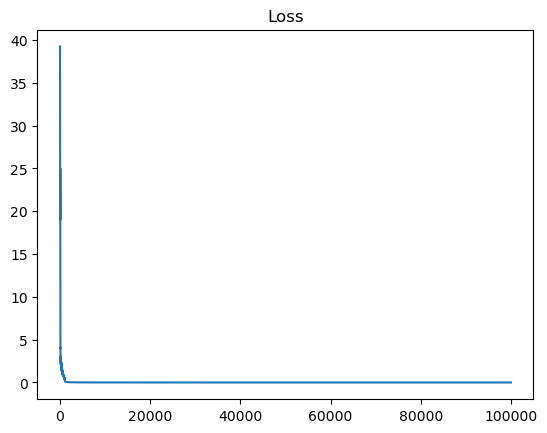

[[9.99884518e-01]
 [9.99999826e-01]
 [2.56684504e-07]
 [9.99999297e-01]
 [9.99999819e-01]
 [2.27171530e-07]
 [9.99999696e-01]
 [9.99999815e-01]
 [2.07800492e-07]
 [9.99999824e-01]
 [9.99999822e-01]
 [9.99999818e-01]
 [1.34977726e-03]
 [9.99999791e-01]
 [2.13727470e-07]
 [9.99999824e-01]
 [2.41551096e-07]
 [9.99999723e-01]
 [9.99999823e-01]
 [2.13505017e-07]
 [2.06228898e-07]
 [9.99999806e-01]
 [1.49502615e-06]
 [2.07964768e-07]
 [2.44582583e-07]
 [2.09214192e-07]
 [2.06332938e-07]
 [2.77491455e-07]
 [2.06798443e-07]
 [2.06654931e-07]
 [2.13811032e-07]
 [2.05598409e-07]
 [9.99999578e-01]
 [3.72193155e-07]
 [9.99999824e-01]
 [2.39726130e-05]
 [9.99999201e-01]
 [9.99912208e-01]
 [9.99999825e-01]
 [9.99999826e-01]
 [9.99999813e-01]
 [9.39566281e-05]
 [2.12553371e-07]
 [2.07588268e-07]
 [9.99999822e-01]
 [9.99979596e-01]
 [9.99999743e-01]
 [1.49393211e-01]
 [2.06873138e-07]
 [9.99999334e-01]
 [2.06970140e-07]
 [9.99999827e-01]
 [9.97318620e-01]
 [9.99999825e-01]
 [9.99982371e-01]
 [2.563384

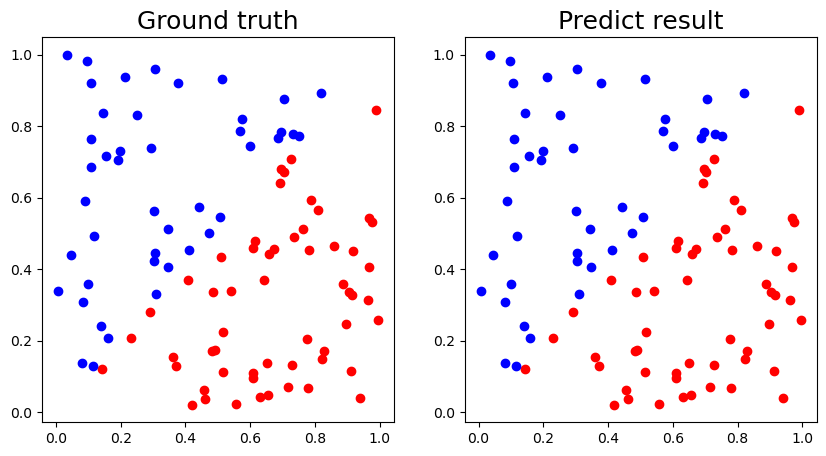

Iter: 0 |	 Ground truth: [1] |	 Predict: [0.99988452]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.99999983]
Iter: 2 |	 Ground truth: [0] |	 Predict: [2.56684504e-07]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.9999993]
Iter: 4 |	 Ground truth: [1] |	 Predict: [0.99999982]
Iter: 5 |	 Ground truth: [0] |	 Predict: [2.2717153e-07]
Iter: 6 |	 Ground truth: [1] |	 Predict: [0.9999997]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.99999981]
Iter: 8 |	 Ground truth: [0] |	 Predict: [2.07800492e-07]
Iter: 9 |	 Ground truth: [1] |	 Predict: [0.99999982]
Iter: 10 |	 Ground truth: [1] |	 Predict: [0.99999982]
Iter: 11 |	 Ground truth: [1] |	 Predict: [0.99999982]
Iter: 12 |	 Ground truth: [0] |	 Predict: [0.00134978]
Iter: 13 |	 Ground truth: [1] |	 Predict: [0.99999979]
Iter: 14 |	 Ground truth: [0] |	 Predict: [2.1372747e-07]
Iter: 15 |	 Ground truth: [1] |	 Predict: [0.99999982]
Iter: 16 |	 Ground truth: [0] |	 Predict: [2.41551096e-07]
Iter: 17 |	 Ground truth: [1] |	 Predict: [0.99999972]
Iter

[39.239331395025694,
 28.728545247921094,
 26.627024302707003,
 28.30076162637386,
 26.21574596305016,
 27.217317339002847,
 25.997186560519317,
 26.553882461405834,
 25.657381589591445,
 25.90359238910871,
 25.33072745966521,
 25.40671089126965,
 25.051538083659526,
 25.050838430476162,
 24.835415937616496,
 24.808545298928802,
 24.67851876908321,
 24.647490674518924,
 24.567665925978083,
 24.53969566122074,
 24.48846919716537,
 24.46449356166606,
 24.428990304430975,
 24.407818874633747,
 24.380397653414843,
 24.36037502782122,
 24.33638010838304,
 24.315898923961353,
 24.29229323741277,
 24.269850104111217,
 24.24439423588059,
 24.218484699487295,
 24.189222955163775,
 24.1581796919278,
 24.123078521116867,
 24.084873655199193,
 24.041511021308153,
 23.99350742430032,
 23.938738742838304,
 23.877357200972664,
 23.806894048013106,
 23.727157249807004,
 23.635008845950058,
 23.529960898619567,
 23.407779327660236,
 23.268041680310375,
 23.10493515380944,
 22.92010924633431,
 22.706350

In [136]:
Traning_and_Test(NN1, generate_linear)

epoch 0, loss: 7.2663335030755745
epoch 5000, loss: 0.009588561772665373
epoch 10000, loss: 0.002242437061225265
epoch 15000, loss: 0.0011749273692717923
epoch 20000, loss: 0.0007750010978761717
epoch 25000, loss: 0.0005705252570179066
epoch 30000, loss: 0.00044786262773810156
epoch 35000, loss: 0.0003666999123645763
epoch 40000, loss: 0.0003093081638805449
epoch 45000, loss: 0.0002667286784500485
epoch 50000, loss: 0.00023396891535854147
epoch 55000, loss: 0.00020803601791415742
epoch 60000, loss: 0.0001870314112865573
epoch 65000, loss: 0.00016969497847109648
epoch 70000, loss: 0.00015515883473650224
epoch 75000, loss: 0.00014280651574923012
epoch 80000, loss: 0.000132188557676896
epoch 85000, loss: 0.00012296983350936218
epoch 90000, loss: 0.00011489556546219941
epoch 95000, loss: 0.00010776873717523804
epoch 100000, loss: 0.00010143469240959112


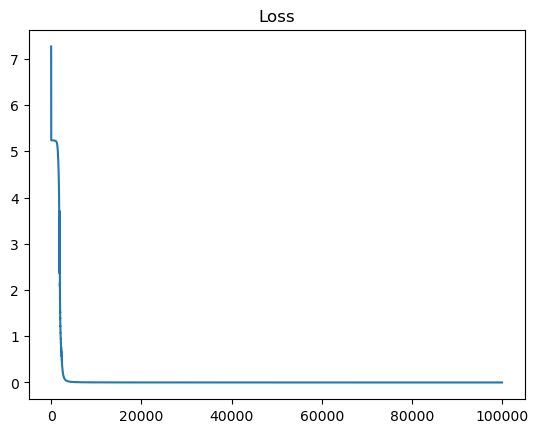

[[1.56107749e-05]
 [9.99997008e-01]
 [1.22375711e-04]
 [9.99996893e-01]
 [8.20732936e-04]
 [9.99996485e-01]
 [2.85695802e-03]
 [9.99991998e-01]
 [4.45044074e-03]
 [9.94772302e-01]
 [3.62810823e-03]
 [2.00879390e-03]
 [9.94797541e-01]
 [9.52584646e-04]
 [9.99991396e-01]
 [4.51698342e-04]
 [9.99995904e-01]
 [2.32086015e-04]
 [9.99996147e-01]
 [1.32968016e-04]
 [9.99996066e-01]]
Accuracy: 1.0


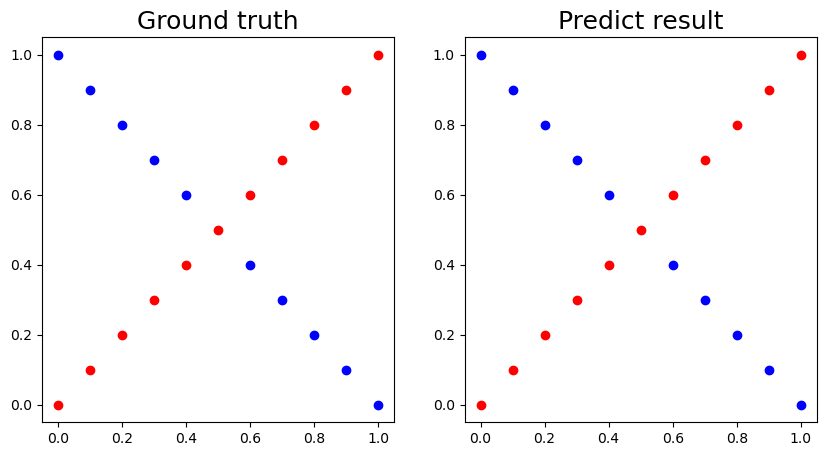

Iter: 0 |	 Ground truth: [0] |	 Predict: [1.56107749e-05]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.99999701]
Iter: 2 |	 Ground truth: [0] |	 Predict: [0.00012238]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.99999689]
Iter: 4 |	 Ground truth: [0] |	 Predict: [0.00082073]
Iter: 5 |	 Ground truth: [1] |	 Predict: [0.99999648]
Iter: 6 |	 Ground truth: [0] |	 Predict: [0.00285696]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.999992]
Iter: 8 |	 Ground truth: [0] |	 Predict: [0.00445044]
Iter: 9 |	 Ground truth: [1] |	 Predict: [0.9947723]
Iter: 10 |	 Ground truth: [0] |	 Predict: [0.00362811]
Iter: 11 |	 Ground truth: [0] |	 Predict: [0.00200879]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.99479754]
Iter: 13 |	 Ground truth: [0] |	 Predict: [0.00095258]
Iter: 14 |	 Ground truth: [1] |	 Predict: [0.9999914]
Iter: 15 |	 Ground truth: [0] |	 Predict: [0.0004517]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.9999959]
Iter: 17 |	 Ground truth: [0] |	 Predict: [0.00023209]
Iter: 18 |	 Ground tru

[7.2663335030755745,
 6.265773915603955,
 5.579277925629418,
 5.318446434205059,
 5.2546758571252985,
 5.241344917690555,
 5.238625586375198,
 5.238067689693879,
 5.23795037185653,
 5.237923179212533,
 5.237914463877796,
 5.237909540506354,
 5.237905395110425,
 5.237901408698816,
 5.237897454096982,
 5.2378935051593905,
 5.237889556496521,
 5.237885606983015,
 5.2378816563693835,
 5.237877704585943,
 5.237873751599863,
 5.237869797385848,
 5.237865841920118,
 5.237861885179187,
 5.237857927139609,
 5.237853967777941,
 5.23785000707072,
 5.237846044994473,
 5.237842081525703,
 5.237838116640902,
 5.237834150316547,
 5.237830182529092,
 5.237826213254976,
 5.237822242470627,
 5.237818270152443,
 5.237814296276813,
 5.2378103208201034,
 5.237806343758663,
 5.2378023650688235,
 5.237798384726892,
 5.23779440270916,
 5.2377904189918985,
 5.237786433551356,
 5.237782446363762,
 5.237778457405325,
 5.23777446665223,
 5.2377704740806434,
 5.237766479666708,
 5.237762483386543,
 5.2377584852162

In [137]:
Traning_and_Test(NN1, generate_XOR_easy)

# Different Learning Rate

epoch 0, loss: 38.64264485081577
epoch 5000, loss: 0.005770781048286226
epoch 10000, loss: 0.002294059825386209
epoch 15000, loss: 0.0013695764968535806
epoch 20000, loss: 0.0009574259514021058
epoch 25000, loss: 0.0007280357922777534
epoch 30000, loss: 0.000583306907190522
epoch 35000, loss: 0.00048429049817929227
epoch 40000, loss: 0.0004125953032374091
epoch 45000, loss: 0.0003584578498626282
epoch 50000, loss: 0.0003162356455349731
epoch 55000, loss: 0.0002824503834185547
epoch 60000, loss: 0.00025484612744526645
epoch 65000, loss: 0.00023189840615325035
epoch 70000, loss: 0.00021254151842894567
epoch 75000, loss: 0.00019600895303577403
epoch 80000, loss: 0.0001817358525297027
epoch 85000, loss: 0.00016929716047887875
epoch 90000, loss: 0.00015836713543247597
epoch 95000, loss: 0.00014869211152389235
epoch 100000, loss: 0.0001400717240185962


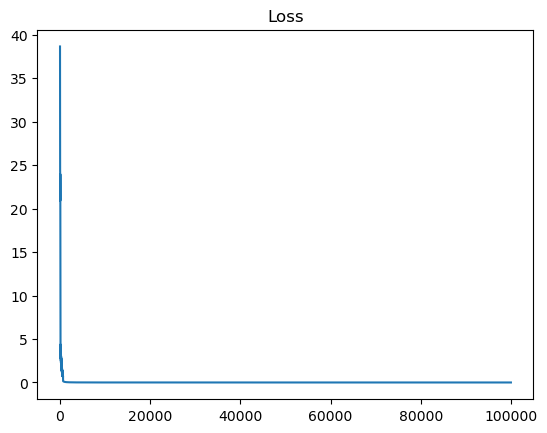

[[2.13300393e-06]
 [9.99999971e-01]
 [9.99999971e-01]
 [9.99999972e-01]
 [9.99999971e-01]
 [5.97349829e-04]
 [5.69806055e-08]
 [9.99999972e-01]
 [9.99999972e-01]
 [9.99999972e-01]
 [8.15255482e-08]
 [6.00157801e-08]
 [5.75746259e-08]
 [9.99999971e-01]
 [9.99999971e-01]
 [2.82008211e-04]
 [8.78264052e-08]
 [9.99999972e-01]
 [8.16832622e-07]
 [9.99999971e-01]
 [9.99999970e-01]
 [9.99999972e-01]
 [9.99999971e-01]
 [9.99999959e-01]
 [1.34829571e-07]
 [2.34784195e-07]
 [5.89926983e-08]
 [6.37947272e-08]
 [9.83314481e-01]
 [9.99999972e-01]
 [9.99999971e-01]
 [1.52749074e-04]
 [5.91743995e-08]
 [9.99999972e-01]
 [9.99999962e-01]
 [7.17944115e-08]
 [1.39486227e-06]
 [9.99999872e-01]
 [1.47917039e-07]
 [5.88425858e-08]
 [9.99999849e-01]
 [9.99999972e-01]
 [9.99999971e-01]
 [9.99999935e-01]
 [9.99999971e-01]
 [9.99999971e-01]
 [6.01361948e-08]
 [5.82218357e-08]
 [6.00781719e-08]
 [5.91458044e-08]
 [1.95650874e-05]
 [9.99999969e-01]
 [9.03927250e-08]
 [5.75121964e-08]
 [9.99999972e-01]
 [9.999999

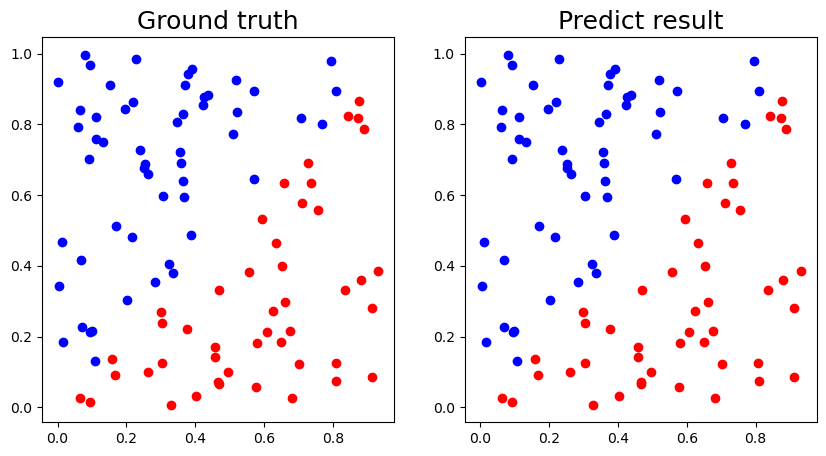

epoch 0, loss: 33.299148159732255
epoch 5000, loss: 24.711328613294548
epoch 10000, loss: 24.70334313786915
epoch 15000, loss: 24.693380533985415
epoch 20000, loss: 24.6805912542243
epoch 25000, loss: 24.66366110071405
epoch 30000, loss: 24.640480189028978
epoch 35000, loss: 24.607510530357253
epoch 40000, loss: 24.558502203689176
epoch 45000, loss: 24.481691155948962
epoch 50000, loss: 24.353127126404903
epoch 55000, loss: 24.11906478620752
epoch 60000, loss: 23.643953808127847
epoch 65000, loss: 22.544918589046883
epoch 70000, loss: 19.78632616949728
epoch 75000, loss: 14.428427084825886
epoch 80000, loss: 9.36899231632736
epoch 85000, loss: 6.503544668428513
epoch 90000, loss: 4.930380250157181
epoch 95000, loss: 3.961598917825043
epoch 100000, loss: 3.3043095207585162


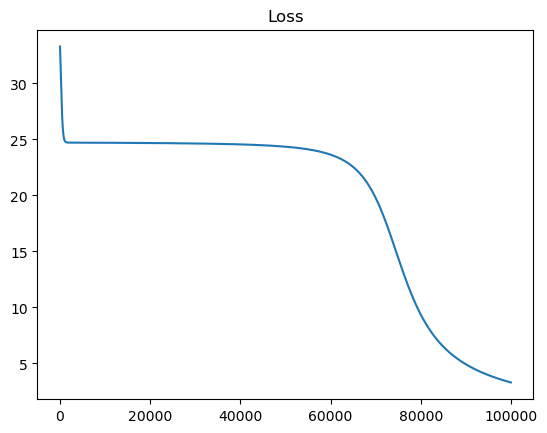

[[0.5037556 ]
 [0.0261485 ]
 [0.01392306]
 [0.97061227]
 [0.18467508]
 [0.43387854]
 [0.9314528 ]
 [0.96939491]
 [0.58919571]
 [0.027431  ]
 [0.02457151]
 [0.98746554]
 [0.0848319 ]
 [0.0302355 ]
 [0.77060243]
 [0.92163136]
 [0.60998006]
 [0.07728775]
 [0.93544602]
 [0.21421717]
 [0.96868291]
 [0.02232099]
 [0.0821614 ]
 [0.54230951]
 [0.9560463 ]
 [0.7300799 ]
 [0.79389722]
 [0.26852329]
 [0.01438528]
 [0.97435621]
 [0.01903625]
 [0.01755762]
 [0.14440204]
 [0.59152497]
 [0.01535223]
 [0.0345281 ]
 [0.33021681]
 [0.98634439]
 [0.74850876]
 [0.02650532]
 [0.01600919]
 [0.98835181]
 [0.9753845 ]
 [0.03884854]
 [0.01325033]
 [0.86273447]
 [0.02148168]
 [0.97708255]
 [0.81385365]
 [0.9668445 ]
 [0.01096627]
 [0.90882247]
 [0.96809375]
 [0.02221324]
 [0.96790528]
 [0.02195746]
 [0.98198144]
 [0.01858577]
 [0.01574926]
 [0.02671697]
 [0.03928123]
 [0.93590059]
 [0.0271703 ]
 [0.94728299]
 [0.37295193]
 [0.95483618]
 [0.64611863]
 [0.81288235]
 [0.91267732]
 [0.91507077]
 [0.61388529]
 [0.65

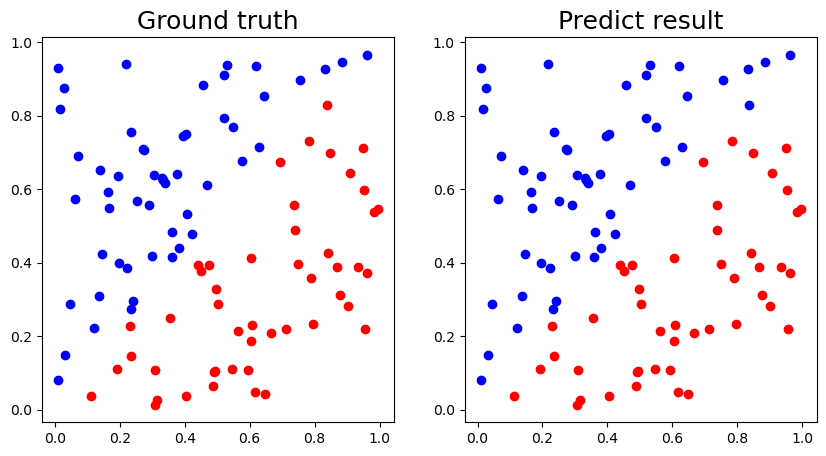

In [14]:
loss1 = Traning_and_Test(NN1, generate_linear, lr = 0.1)
loss2 = Traning_and_Test(NN1, generate_linear, lr = 0.0001)

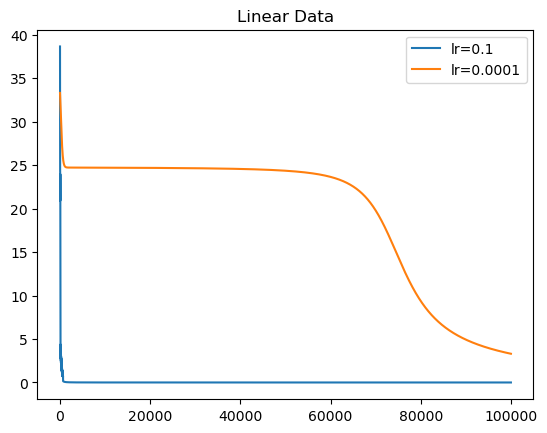

In [15]:
plt.plot(loss1, label='lr=0.1')
plt.plot(loss2, label='lr=0.0001')
plt.title('Linear Data')
plt.legend()
plt.show()

epoch 0, loss: 8.610410240464077
epoch 5000, loss: 0.011276308628864853
epoch 10000, loss: 0.002556846587285868
epoch 15000, loss: 0.0013403466637370402
epoch 20000, loss: 0.000886518209149885
epoch 25000, loss: 0.0006544624659718545
epoch 30000, loss: 0.0005150924913374085
epoch 35000, loss: 0.00042273882426393345
epoch 40000, loss: 0.00035733331753582493
epoch 45000, loss: 0.00030873513145911343
epoch 50000, loss: 0.00027129061948169564
epoch 55000, loss: 0.00024160852413280693
epoch 60000, loss: 0.00021753598010970806
epoch 65000, loss: 0.0001976429831245955
epoch 70000, loss: 0.00018094385424651836
epoch 75000, loss: 0.0001667378967444229
epoch 80000, loss: 0.00015451382608788793
epoch 85000, loss: 0.00014389012223617955
epoch 90000, loss: 0.0001345765152086814
epoch 95000, loss: 0.0001263483752833597
epoch 100000, loss: 0.00011902924175504524


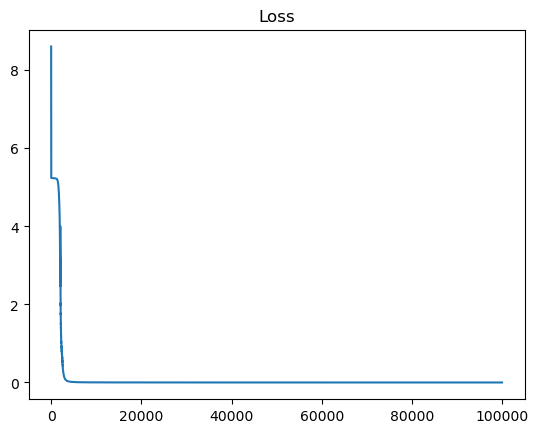

[[6.60319646e-05]
 [9.99972340e-01]
 [2.76681192e-04]
 [9.99971772e-01]
 [1.19048892e-03]
 [9.99969889e-01]
 [3.29932074e-03]
 [9.99952950e-01]
 [4.70776450e-03]
 [9.94392087e-01]
 [3.83359568e-03]
 [2.26876174e-03]
 [9.94430785e-01]
 [1.21377720e-03]
 [9.99952532e-01]
 [6.71190181e-04]
 [9.99968466e-01]
 [4.06209127e-04]
 [9.99969445e-01]
 [2.71945571e-04]
 [9.99969087e-01]]
Accuracy: 1.0


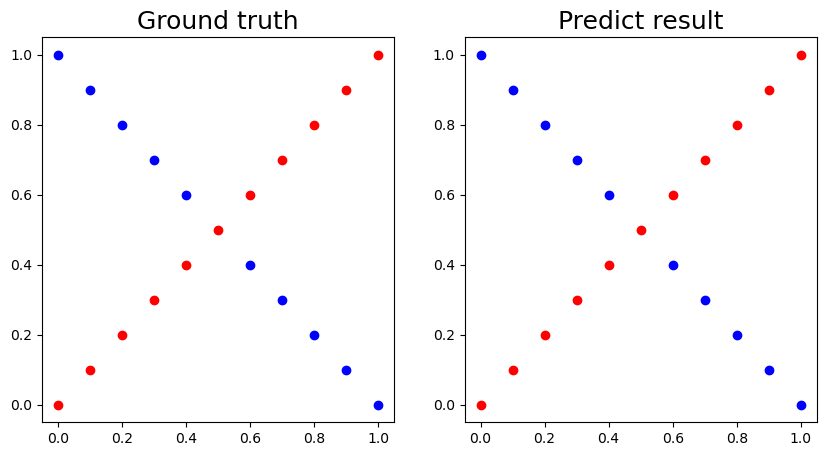

epoch 0, loss: 7.941983430722519
epoch 5000, loss: 5.2475086710312935
epoch 10000, loss: 5.239113395221688
epoch 15000, loss: 5.239100047679595
epoch 20000, loss: 5.23909454715237
epoch 25000, loss: 5.239089078930798
epoch 30000, loss: 5.2390836354123325
epoch 35000, loss: 5.2390782163711735
epoch 40000, loss: 5.2390728215903515
epoch 45000, loss: 5.239067450854632
epoch 50000, loss: 5.239062103950479
epoch 55000, loss: 5.239056780666038
epoch 60000, loss: 5.239051480791115
epoch 65000, loss: 5.2390462041171535
epoch 70000, loss: 5.239040950437224
epoch 75000, loss: 5.239035719545993
epoch 80000, loss: 5.239030511239708
epoch 85000, loss: 5.239025325316179
epoch 90000, loss: 5.239020161574766
epoch 95000, loss: 5.239015019816348
epoch 100000, loss: 5.239009899843313


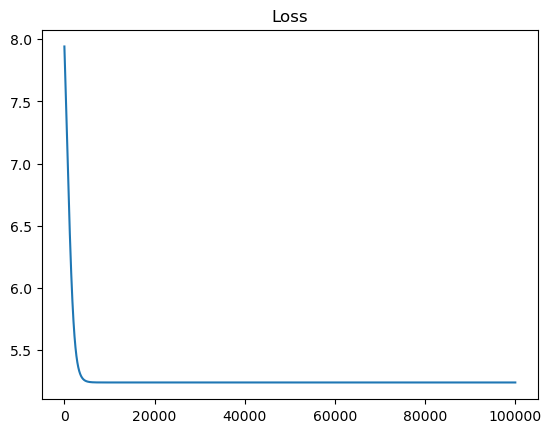

[[0.47746784]
 [0.47677182]
 [0.47726088]
 [0.47674478]
 [0.47707454]
 [0.47671745]
 [0.47690846]
 [0.47668987]
 [0.47676198]
 [0.47666207]
 [0.47663411]
 [0.47652366]
 [0.47660602]
 [0.47642928]
 [0.47657785]
 [0.47634952]
 [0.47654966]
 [0.47628288]
 [0.47652148]
 [0.47622788]
 [0.47649338]]
Accuracy: 0.5238095238095238


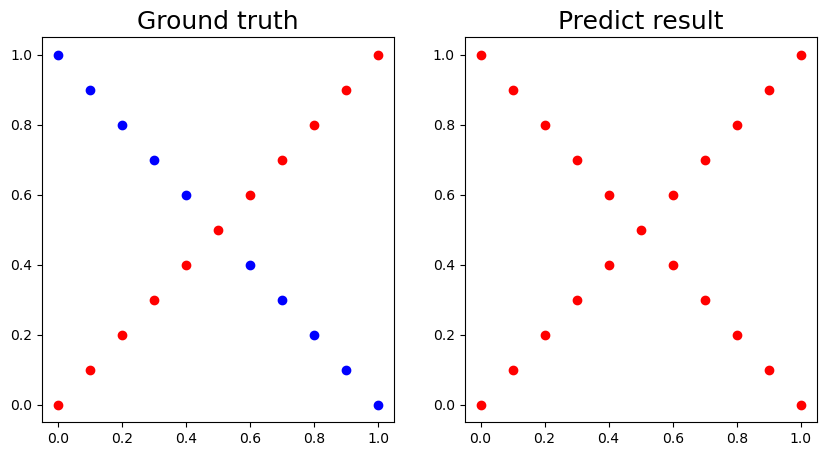

In [11]:
loss1 = Traning_and_Test(NN1, generate_XOR_easy, lr = 0.1)
loss2 = Traning_and_Test(NN1, generate_XOR_easy, lr = 0.0001)

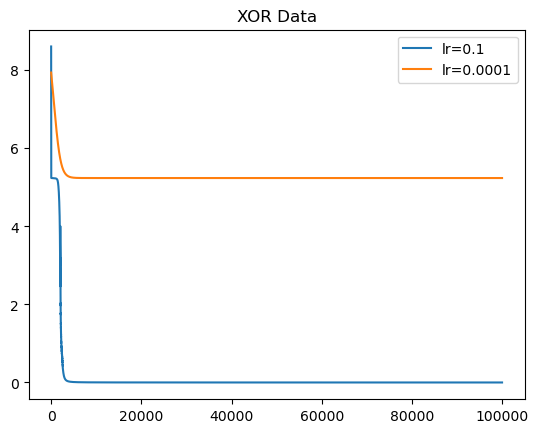

In [12]:
plt.plot(loss1, label='lr=0.1')
plt.plot(loss2, label='lr=0.0001')
plt.title('XOR Data')
plt.legend()
plt.show()

# Difference numbers of hidden units

epoch 0, loss: 23.92682580529979
epoch 5000, loss: 0.013259962763113312
epoch 10000, loss: 0.004399936891987228
epoch 15000, loss: 0.0024576262843334943
epoch 20000, loss: 0.0016576838063813862
epoch 25000, loss: 0.001232225675196255
epoch 30000, loss: 0.0009717455536141356
epoch 35000, loss: 0.0007973545538094069
epoch 40000, loss: 0.000673143480548475
epoch 45000, loss: 0.0005805624084663283
epoch 50000, loss: 0.0005091170046394352
epoch 55000, loss: 0.0004524483734687511
epoch 60000, loss: 0.00040649061774209773
epoch 65000, loss: 0.0003685290036995913
epoch 70000, loss: 0.00033668523584404994
epoch 75000, loss: 0.00030962039679971297
epoch 80000, loss: 0.00028635555328595835
epoch 85000, loss: 0.00026615918461495605
epoch 90000, loss: 0.0002484741817773096
epoch 95000, loss: 0.00023286913836194733
epoch 100000, loss: 0.00021900502836220598


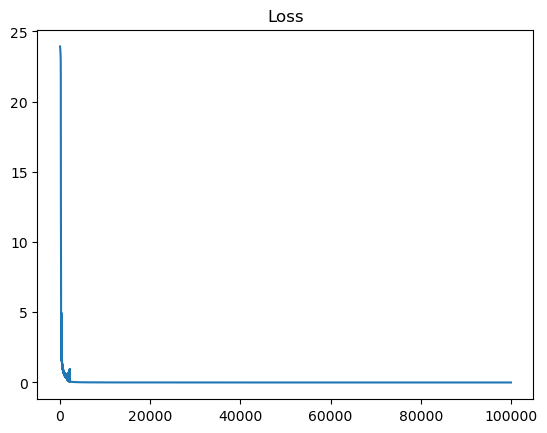

[[9.99996220e-01]
 [3.72495867e-08]
 [9.99996218e-01]
 [9.99996226e-01]
 [9.99996220e-01]
 [2.49555422e-08]
 [2.49098238e-08]
 [9.99996156e-01]
 [9.99996221e-01]
 [9.99996225e-01]
 [2.49123712e-08]
 [9.45623202e-05]
 [9.99995916e-01]
 [9.99996218e-01]
 [4.08313056e-08]
 [9.99996200e-01]
 [9.99992176e-01]
 [9.99976599e-01]
 [9.99996209e-01]
 [4.18987780e-08]
 [2.49944565e-08]
 [2.49794883e-08]
 [2.62659129e-08]
 [9.99996208e-01]
 [9.99996104e-01]
 [2.52505268e-08]
 [2.56410263e-08]
 [9.99994431e-01]
 [9.99996168e-01]
 [8.64709072e-05]
 [2.60111169e-08]
 [2.51452022e-08]
 [9.99996224e-01]
 [9.99996105e-01]
 [4.49636929e-08]
 [9.99993945e-01]
 [6.20245411e-07]
 [9.99996220e-01]
 [9.99995818e-01]
 [2.51002924e-08]
 [9.99996221e-01]
 [9.99996224e-01]
 [2.49557106e-08]
 [9.99996204e-01]
 [9.99993980e-01]
 [2.49839310e-08]
 [2.50295061e-08]
 [4.28025839e-08]
 [2.84293807e-08]
 [9.99996212e-01]
 [9.93405988e-01]
 [2.49507594e-08]
 [9.99996220e-01]
 [1.50193546e-07]
 [2.92762551e-08]
 [3.581395

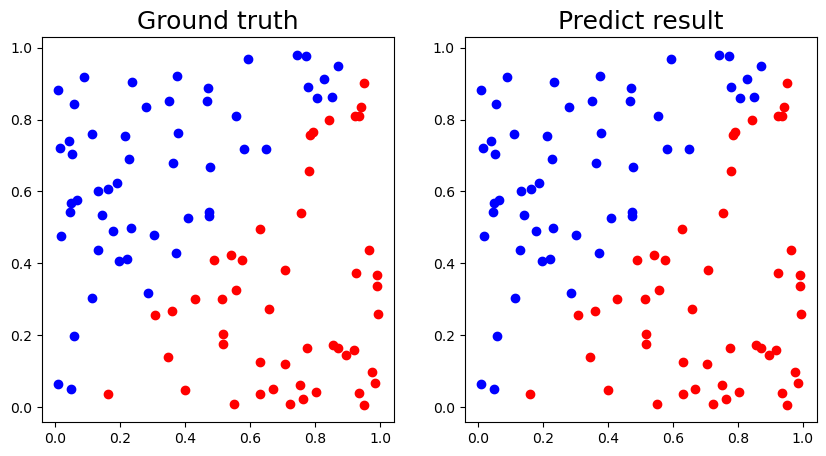

epoch 0, loss: 44.530143752952284
epoch 5000, loss: 0.009251448421456036
epoch 10000, loss: 0.0035436935550217526
epoch 15000, loss: 0.002070431693847531
epoch 20000, loss: 0.001427041375596797
epoch 25000, loss: 0.0010742279777276324
epoch 30000, loss: 0.0008541239717904535
epoch 35000, loss: 0.0007048769191112836
epoch 40000, loss: 0.0005975942870219903
epoch 45000, loss: 0.0005170749886094688
epoch 50000, loss: 0.00045460081891976055
epoch 55000, loss: 0.0004048327149140676
epoch 60000, loss: 0.000364327769799347
epoch 65000, loss: 0.0003307712024878865
epoch 70000, loss: 0.0003025521558391587
epoch 75000, loss: 0.00027851672468586305
epoch 80000, loss: 0.0002578177043468584
epoch 85000, loss: 0.00023981970945169057
epoch 90000, loss: 0.00022403730830816509
epoch 95000, loss: 0.00021009354657446162
epoch 100000, loss: 0.00019769145370527534


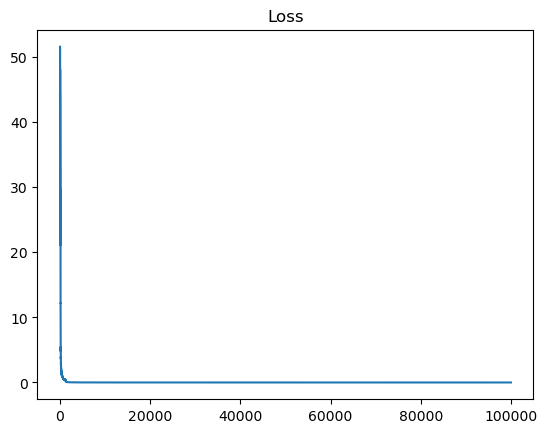

[[1.00000000e+00]
 [2.65326046e-08]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [3.62337173e-08]
 [5.10606253e-08]
 [2.17401555e-08]
 [1.85326693e-07]
 [8.77861002e-05]
 [1.00000000e+00]
 [2.16440031e-08]
 [9.81807747e-01]
 [2.25783685e-08]
 [1.00000000e+00]
 [1.00000000e+00]
 [3.13411711e-08]
 [1.00000000e+00]
 [1.44208303e-07]
 [1.00000000e+00]
 [4.62051179e-08]
 [1.00000000e+00]
 [1.00000000e+00]
 [5.01772316e-08]
 [2.35367099e-08]
 [1.00000000e+00]
 [2.17582755e-08]
 [1.00000000e+00]
 [2.32264097e-08]
 [1.00000000e+00]
 [9.99999991e-01]
 [2.29336798e-08]
 [1.00000000e+00]
 [9.99999903e-01]
 [1.93113368e-02]
 [1.00000000e+00]
 [4.17044093e-08]
 [3.07702399e-08]
 [9.22645658e-07]
 [2.36074824e-08]
 [3.66269228e-07]
 [2.38213957e-08]
 [9.27388446e-07]
 [1.00000000e+00]
 [2.09741298e-08]
 [1.00000000e+00]
 [2.23346252e-08]
 [1.00000000e+00]
 [2.47267588e-06]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.000000

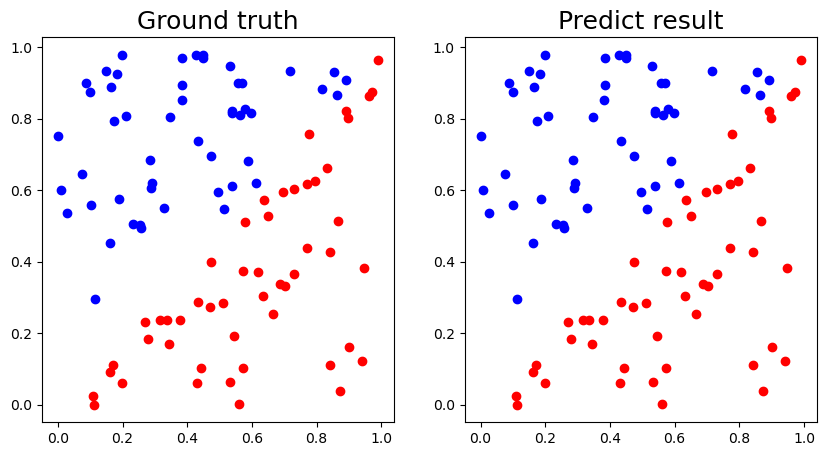

In [17]:
loss1 = Traning_and_Test(NN1, generate_linear, n_hidden=2)
loss2 = Traning_and_Test(NN1, generate_linear, n_hidden=8)

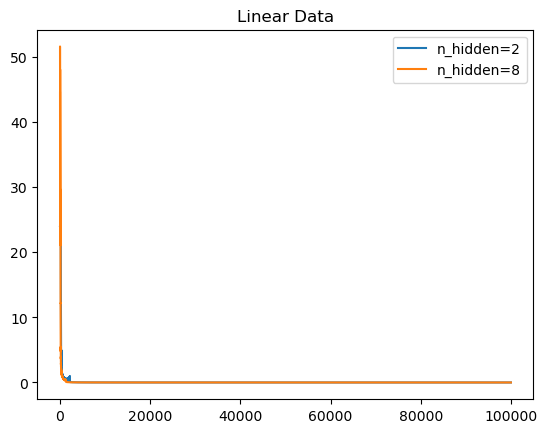

In [18]:
plt.plot(loss1, label='n_hidden=2')
plt.plot(loss2, label='n_hidden=8')
plt.title('Linear Data')
plt.legend()
plt.show()

epoch 0, loss: 5.590023203339057
epoch 5000, loss: 4.152888562599893
epoch 10000, loss: 4.0394053286874225
epoch 15000, loss: 3.9925636467079535
epoch 20000, loss: 3.963581327978725
epoch 25000, loss: 3.9434657435047553
epoch 30000, loss: 3.9284293607486402
epoch 35000, loss: 3.9164565725185243
epoch 40000, loss: 3.906344454981269
epoch 45000, loss: 3.8973022354048146
epoch 50000, loss: 3.8887475726390446
epoch 55000, loss: 4.333460562721938
epoch 60000, loss: 4.3399910186024
epoch 65000, loss: 4.609038553917541
epoch 70000, loss: 3.812248662623545
epoch 75000, loss: 3.5729958505752393
epoch 80000, loss: 4.663072174408183
epoch 85000, loss: 3.0265071206898533
epoch 90000, loss: 2.4438957301383577
epoch 95000, loss: 2.345477064126957
epoch 100000, loss: 2.2903768122660093


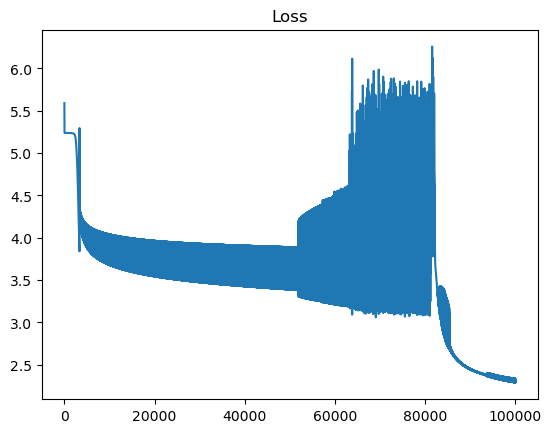

[[7.95431351e-11]
 [9.52253886e-01]
 [7.95090394e-11]
 [9.41961176e-01]
 [7.98724449e-11]
 [9.29381596e-01]
 [1.81594432e-10]
 [9.16241695e-01]
 [1.97523474e-03]
 [9.04099672e-01]
 [8.94012714e-01]
 [6.20306375e-01]
 [8.86257970e-01]
 [5.25281298e-01]
 [8.80094852e-01]
 [5.06482342e-01]
 [8.73395974e-01]
 [5.02103437e-01]
 [8.61744990e-01]
 [5.00844178e-01]
 [8.35838270e-01]]
Accuracy: 0.7142857142857143


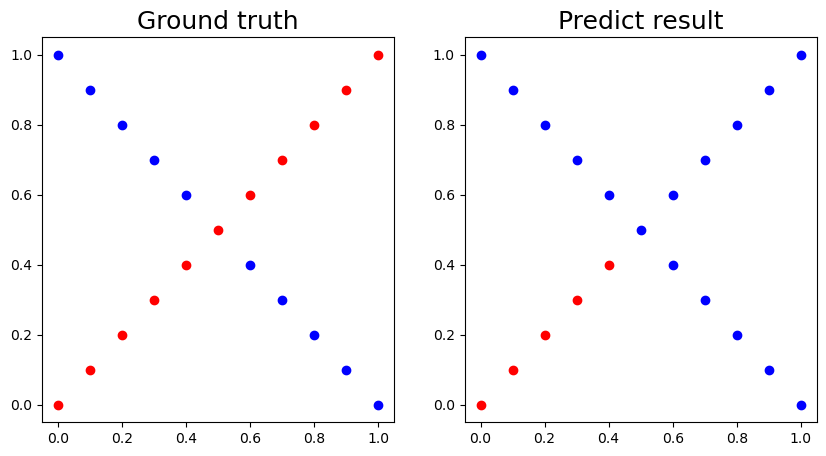

epoch 0, loss: 10.86499558565331
epoch 5000, loss: 0.009028509586342973
epoch 10000, loss: 0.002579846349471631
epoch 15000, loss: 0.0014706730081290144
epoch 20000, loss: 0.0010215159044546715
epoch 25000, loss: 0.000780081551228024
epoch 30000, loss: 0.0006298518625513194
epoch 35000, loss: 0.0005275605392782791
epoch 40000, loss: 0.00045351376751312094
epoch 45000, loss: 0.0003974818242650755
epoch 50000, loss: 0.00035363154218637845
epoch 55000, loss: 0.0003183968898768676
epoch 60000, loss: 0.00028947668884708955
epoch 65000, loss: 0.00026532032831478794
epoch 70000, loss: 0.00024484528265313716
epoch 75000, loss: 0.00022727314458522517
epoch 80000, loss: 0.00021202999805420577
epoch 85000, loss: 0.00019868350671385057
epoch 90000, loss: 0.0001869018575598173
epoch 95000, loss: 0.00017642619348527452
epoch 100000, loss: 0.00016705163677097762


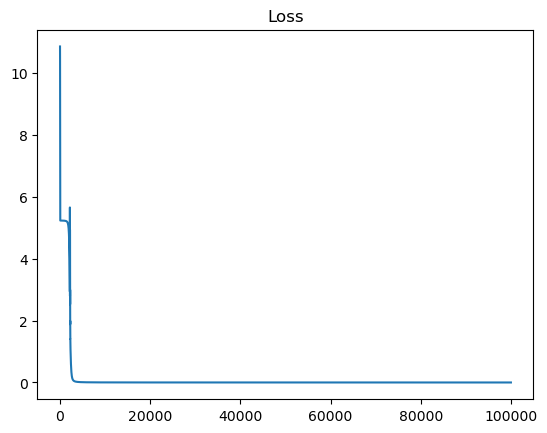

[[0.00179248]
 [0.99765701]
 [0.0023603 ]
 [0.99771384]
 [0.00297083]
 [0.99778581]
 [0.00343168]
 [0.9978332 ]
 [0.00356745]
 [0.99418329]
 [0.00337723]
 [0.00300495]
 [0.99437235]
 [0.00259555]
 [0.9995946 ]
 [0.00222744]
 [0.99968421]
 [0.00192466]
 [0.99970003]
 [0.00168494]
 [0.99970425]]
Accuracy: 1.0


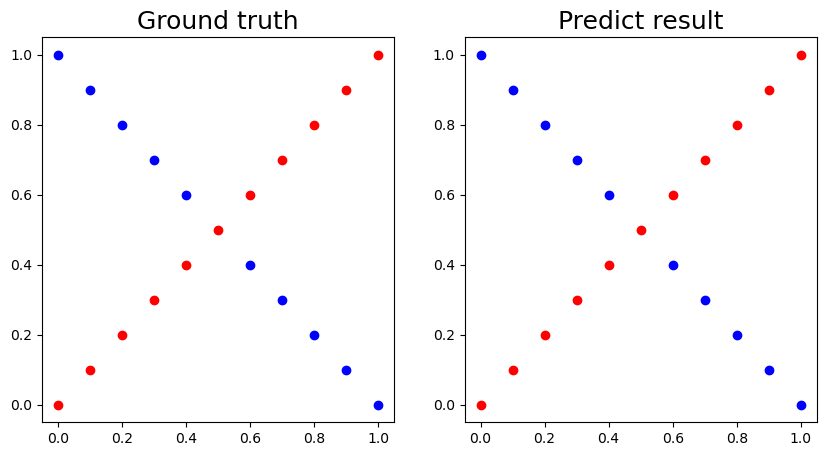

In [20]:
loss1 = Traning_and_Test(NN1, generate_XOR_easy, n_hidden=2)
loss2 = Traning_and_Test(NN1, generate_XOR_easy, n_hidden=8)

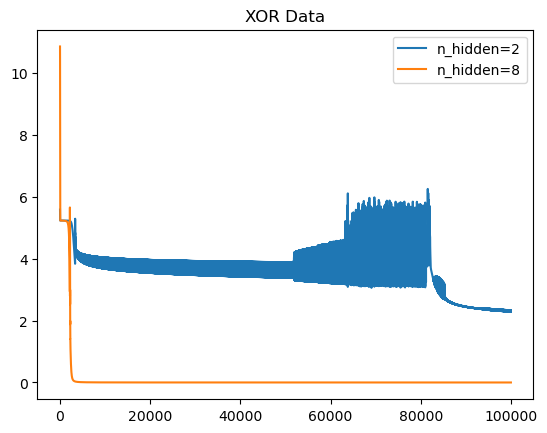

In [21]:
plt.plot(loss1, label='n_hidden=2')
plt.plot(loss2, label='n_hidden=8')
plt.title('XOR Data')
plt.legend()
plt.show()

In [30]:
class NN_wo_activation:
    def __init__(self, X, Y, n_hidden=4, lr=0.1):
        self.X = X
        self.Y = Y
        self.n_hidden = n_hidden
        self.weights1 = Linear(self.X.shape[1], self.n_hidden)
        self.weights2 = Linear(self.n_hidden, self.n_hidden)
        self.weights3 = Linear(self.n_hidden, 1)
        self.lr = lr
        self.optimizer = SGD([self.weights1, self.weights2, self.weights3], self.lr)

    def forward(self, input):
        self.a1 = self.weights1.forward(input)
        self.a2 = self.weights2.forward(self.a1)
        self.a3 = self.weights3.forward(self.a2)
        return self.a3
    
    def train(self):
        y = self.forward(self.X)
        loss = np.sum((y-self.Y)**2)
        
        # Backpropagation
        dloss_dy = 2*(y-self.Y)
        dou_da3 = self.weights3.backward(dloss_dy)
        da2_da1 = self.weights2.backward(dou_da3)
        da1_dw1 = self.weights1.backward(da2_da1)
        
        # Update Weights
        self.optimizer.step()

        return loss

epoch 0, loss: 306.7277472154751
epoch 5000, loss: 13.405295916809493
epoch 10000, loss: 13.405295916809493
epoch 15000, loss: 13.405295916809493
epoch 20000, loss: 13.405295916809493
epoch 25000, loss: 13.405295916809493
epoch 30000, loss: 13.405295916809493
epoch 35000, loss: 13.405295916809493
epoch 40000, loss: 13.405295916809493
epoch 45000, loss: 13.405295916809493
epoch 50000, loss: 13.405295916809493
epoch 55000, loss: 13.405295916809493
epoch 60000, loss: 13.405295916809493
epoch 65000, loss: 13.405295916809493
epoch 70000, loss: 13.405295916809493
epoch 75000, loss: 13.405295916809493
epoch 80000, loss: 13.405295916809493
epoch 85000, loss: 13.405295916809493
epoch 90000, loss: 13.405295916809493
epoch 95000, loss: 13.405295916809493
epoch 100000, loss: 13.405295916809493


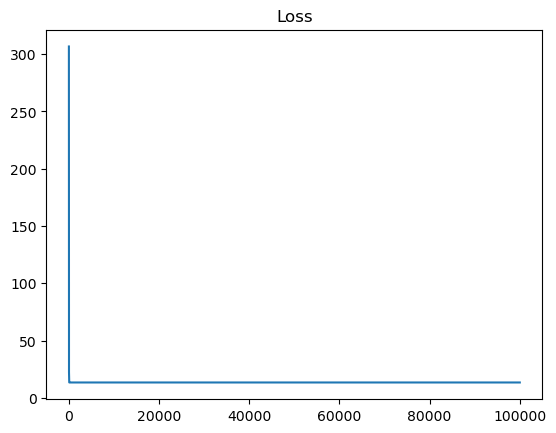

[[-0.07885516]
 [-0.12804342]
 [-0.43397674]
 [ 0.19812139]
 [-0.35280629]
 [-0.0306999 ]
 [ 0.58480286]
 [ 0.80813328]
 [-0.02991124]
 [ 1.07329288]
 [ 1.05552711]
 [ 0.12903313]
 [ 0.71586399]
 [ 0.08481873]
 [ 0.5491145 ]
 [-0.03209262]
 [ 0.06091311]
 [ 0.1210443 ]
 [ 0.58831202]
 [ 0.07636989]
 [ 0.60293105]
 [ 0.83582217]
 [ 0.88272979]
 [-0.03151021]
 [ 0.80693801]
 [ 0.12591928]
 [ 0.74718213]
 [ 0.4675003 ]
 [ 0.4268022 ]
 [ 1.1900657 ]
 [ 0.04883814]
 [ 0.14577373]
 [ 0.14786126]
 [-0.26191562]
 [ 1.0219142 ]
 [-0.38427904]
 [ 1.02721191]
 [ 0.05615636]
 [ 1.15500143]
 [ 0.19943764]
 [ 0.59706015]
 [ 0.23481593]
 [-0.23882491]
 [ 1.22558899]
 [ 0.29587615]
 [-0.12797545]
 [ 0.47887356]
 [-0.04785212]
 [ 1.02010476]
 [ 0.84230622]
 [ 0.67031513]
 [ 0.5010693 ]
 [-0.51168779]
 [ 0.95182031]
 [ 0.59844223]
 [ 0.12453546]
 [-0.10204407]
 [ 1.27428619]
 [ 0.56076223]
 [ 0.12111138]
 [-0.04776968]
 [ 0.32429395]
 [-0.27028613]
 [ 0.93754035]
 [-0.34966975]
 [ 0.40631339]
 [ 0.86627

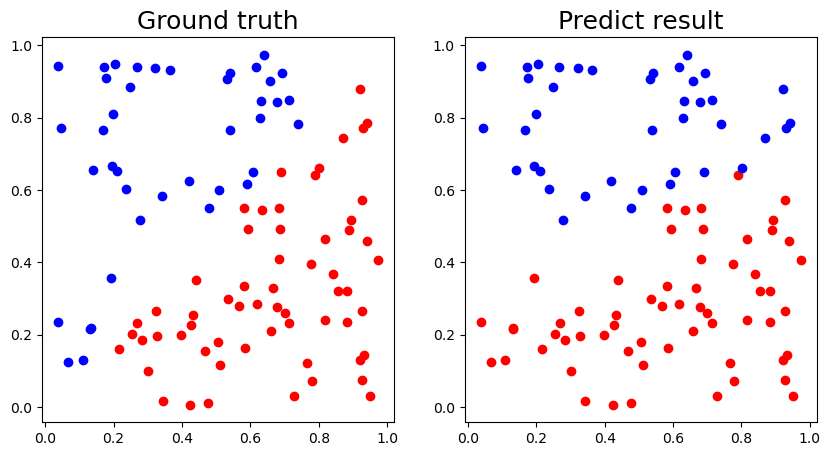

epoch 0, loss: 39.45304302044262
epoch 5000, loss: 24.834720947389954
epoch 10000, loss: 24.787534399699442
epoch 15000, loss: 22.660048828425165
epoch 20000, loss: 1.722793699869532
epoch 25000, loss: 0.7536584861190803
epoch 30000, loss: 0.4539176028555173
epoch 35000, loss: 0.31467025349176125
epoch 40000, loss: 0.23630053066327644
epoch 45000, loss: 0.18680436473051115
epoch 50000, loss: 0.1530307811425848
epoch 55000, loss: 0.12867377576235944
epoch 60000, loss: 0.11036466829746618
epoch 65000, loss: 0.09615311297127363
epoch 70000, loss: 0.08483716011861639
epoch 75000, loss: 0.07563816964469187
epoch 80000, loss: 0.06803073158336471
epoch 85000, loss: 0.061648081627411935
epoch 90000, loss: 0.056226769817567815
epoch 95000, loss: 0.05157288017140068
epoch 100000, loss: 0.047540640348710556


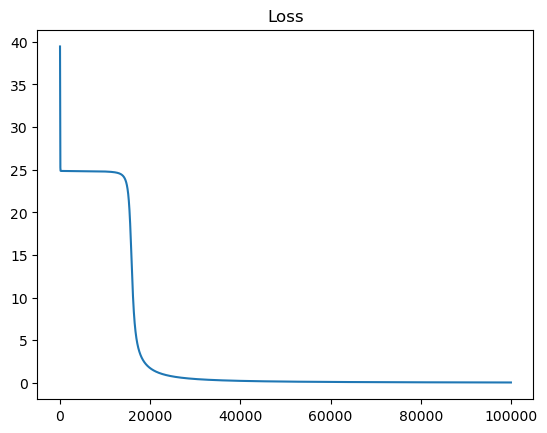

[[1.39261133e-04]
 [9.99913822e-01]
 [9.99929584e-01]
 [3.53189411e-05]
 [9.72914163e-01]
 [9.99907271e-01]
 [1.60667673e-02]
 [3.99439891e-05]
 [1.96740345e-02]
 [9.99908897e-01]
 [3.71794193e-05]
 [9.98196142e-01]
 [1.74090463e-03]
 [4.04810212e-05]
 [3.17141840e-05]
 [3.23138749e-05]
 [9.99935768e-01]
 [9.99925284e-01]
 [9.99924499e-01]
 [2.90001099e-05]
 [2.88328530e-05]
 [9.99927768e-01]
 [9.99860345e-01]
 [2.91470720e-04]
 [9.99912103e-01]
 [9.99934920e-01]
 [9.26414770e-05]
 [9.99904025e-01]
 [3.71271841e-05]
 [9.99822214e-01]
 [1.03783873e-04]
 [1.47452195e-04]
 [9.99657033e-01]
 [3.46108547e-05]
 [7.77212479e-02]
 [4.39254104e-05]
 [9.85744742e-05]
 [1.65014434e-02]
 [8.87952034e-03]
 [6.32170532e-05]
 [1.98725904e-02]
 [9.99934558e-01]
 [9.35561738e-04]
 [6.29618828e-05]
 [8.84342752e-05]
 [1.13227904e-04]
 [9.99912613e-01]
 [9.99891451e-01]
 [9.99251621e-01]
 [8.99095412e-03]
 [9.99926942e-01]
 [3.64997889e-04]
 [9.99766794e-01]
 [9.99926434e-01]
 [2.35477175e-04]
 [3.441864

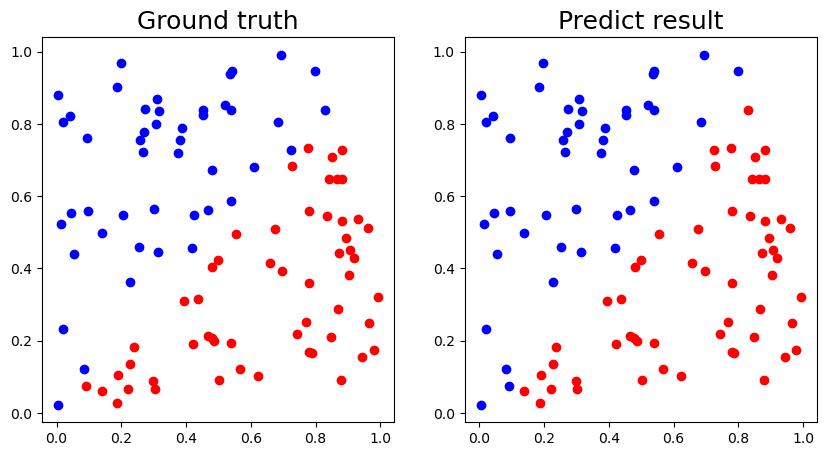

In [37]:
loss1 = Traning_and_Test(NN_wo_activation, generate_linear, lr=0.001)
loss2 = Traning_and_Test(NN1, generate_linear, lr=0.001)

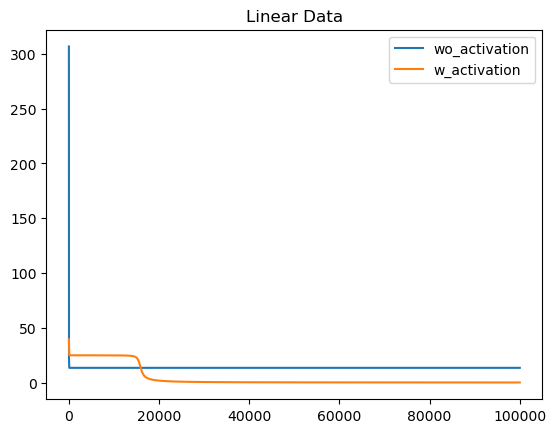

In [38]:
loss_cmp(loss1, loss2, 'wo_activation', 'w_activation', 'Linear Data')

epoch 0, loss: 30.10293084173565
epoch 5000, loss: 6.062992125984252
epoch 10000, loss: 6.062992125984252
epoch 15000, loss: 6.062992125984252
epoch 20000, loss: 6.062992125984252
epoch 25000, loss: 6.062992125984252
epoch 30000, loss: 6.062992125984252
epoch 35000, loss: 6.062992125984252
epoch 40000, loss: 6.062992125984252
epoch 45000, loss: 6.062992125984252
epoch 50000, loss: 6.062992125984252
epoch 55000, loss: 6.062992125984252
epoch 60000, loss: 6.062992125984252
epoch 65000, loss: 6.062992125984252
epoch 70000, loss: 6.062992125984252
epoch 75000, loss: 6.062992125984252
epoch 80000, loss: 6.062992125984252
epoch 85000, loss: 6.062992125984252
epoch 90000, loss: 6.062992125984252
epoch 95000, loss: 6.062992125984252
epoch 100000, loss: 6.062992125984252


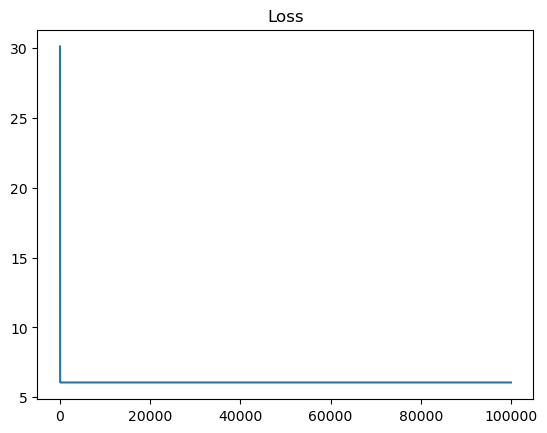

[[0.        ]
 [0.39370079]
 [0.07874016]
 [0.39370079]
 [0.15748031]
 [0.39370079]
 [0.23622047]
 [0.39370079]
 [0.31496063]
 [0.39370079]
 [0.39370079]
 [0.47244094]
 [0.39370079]
 [0.5511811 ]
 [0.39370079]
 [0.62992126]
 [0.39370079]
 [0.70866142]
 [0.39370079]
 [0.78740157]
 [0.39370079]]
Accuracy: 0.3333333333333333


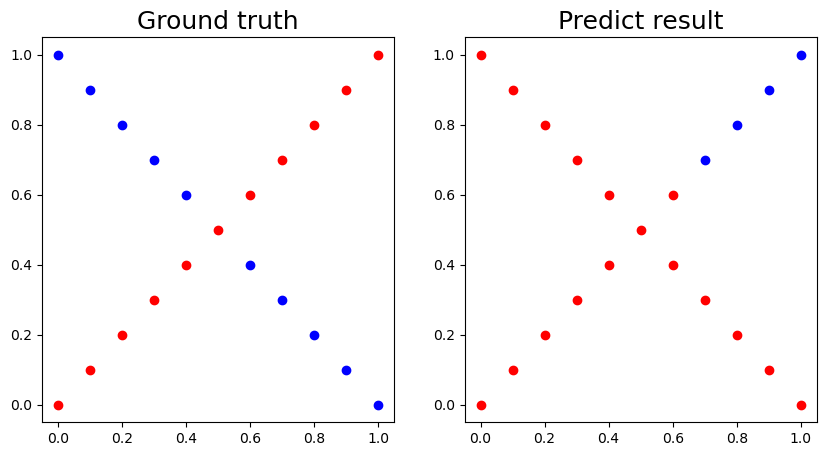

epoch 0, loss: 9.109798946937934
epoch 5000, loss: 5.23959461307729
epoch 10000, loss: 5.239479366438389
epoch 15000, loss: 5.239366866592429
epoch 20000, loss: 5.2392559900143585
epoch 25000, loss: 5.239145638159331
epoch 30000, loss: 5.239034722014356
epoch 35000, loss: 5.238922146744564
epoch 40000, loss: 5.238806795974865
epoch 45000, loss: 5.238687515223411
epoch 50000, loss: 5.23856309395087
epoch 55000, loss: 5.238432245605237
epoch 60000, loss: 5.238293584918944
epoch 65000, loss: 5.238145601543662
epoch 70000, loss: 5.237986628873832
epoch 75000, loss: 5.2378148065918815
epoch 80000, loss: 5.237628035037022
epoch 85000, loss: 5.237423918913082
epoch 90000, loss: 5.237199697048331
epoch 95000, loss: 5.23695215381337
epoch 100000, loss: 5.2366775062621285


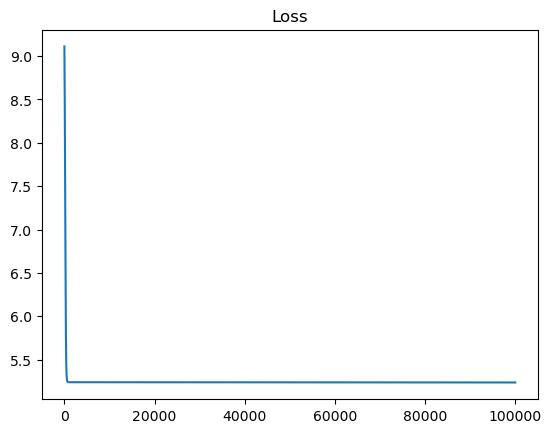

[[0.47746141]
 [0.47670962]
 [0.47751287]
 [0.47684408]
 [0.47753303]
 [0.47698046]
 [0.47752041]
 [0.47711865]
 [0.4774754 ]
 [0.47725854]
 [0.47740001]
 [0.47729745]
 [0.47754292]
 [0.47717171]
 [0.47768714]
 [0.47702713]
 [0.47783253]
 [0.47686806]
 [0.47797893]
 [0.47669861]
 [0.4781262 ]]
Accuracy: 0.5238095238095238


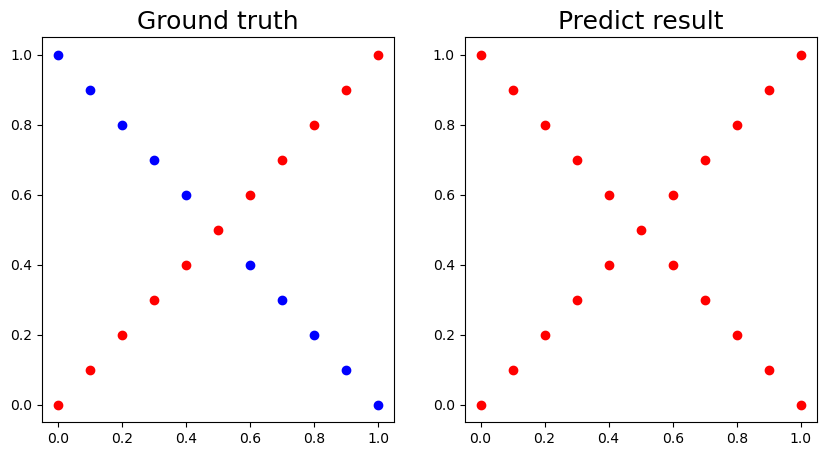

In [39]:
loss1 = Traning_and_Test(NN_wo_activation, generate_XOR_easy, lr=0.001)
loss2 = Traning_and_Test(NN1, generate_XOR_easy, lr=0.001)

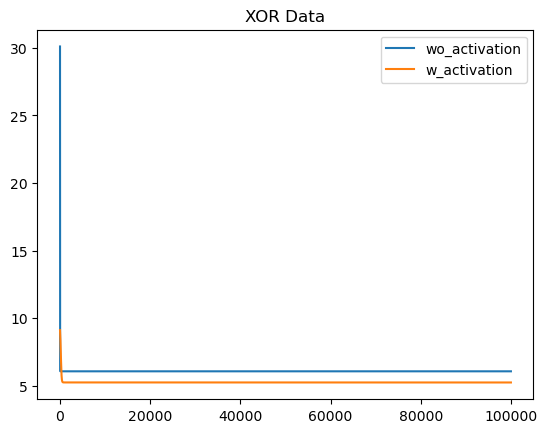

In [40]:
loss_cmp(loss1, loss2, 'wo_activation', 'w_activation', 'XOR Data')

In [49]:
class NN_relu:
    def __init__(self, X, Y, n_hidden=4, lr=0.1):
        self.X = X
        self.Y = Y
        self.n_hidden = n_hidden
        self.weights1 = Linear(self.X.shape[1], self.n_hidden)
        self.weights2 = Linear(self.n_hidden, self.n_hidden)
        self.weights3 = Linear(self.n_hidden, 1)
        self.relu1 = ReLU()
        self.relu2 = ReLU()
        self.relu3 = ReLU()
        self.lr = lr
        self.optimizer = SGD([self.weights1, self.weights2, self.weights3], self.lr)

    def forward(self, input):
        self.a1 = self.weights1.forward(input)
        self.b1 = self.relu1.forward(self.a1)
        self.a2 = self.weights2.forward(self.b1)
        self.b2 = self.relu2.forward(self.a2)
        self.a3 = self.weights3.forward(self.b2)
        self.out = self.relu3.forward(self.a3)
        return self.out
    
    def train(self):
        y = self.forward(self.X)
        loss = np.sum((y-self.Y)**2)
        
        # Backpropagation
        dloss_dy = 2*(y-self.Y)
        dou_da3 = self.relu3.backward(dloss_dy)
        da3_db2 = self.weights3.backward(dou_da3)
        db2_da2 = self.relu2.backward(da3_db2)
        da2_db1 = self.weights2.backward(db2_da2)
        db1_da1 = self.relu1.backward(da2_db1)
        da1_dw1 = self.weights1.backward(db1_da1)
        
        # Update Weights
        self.optimizer.step()

        return loss

epoch 0, loss: 871.0242080431849
epoch 5000, loss: 10.164416802376266
epoch 10000, loss: 10.164416802376266
epoch 15000, loss: 10.164416802376266
epoch 20000, loss: 10.164416802376266
epoch 25000, loss: 10.164416802376266
epoch 30000, loss: 10.164416802376266
epoch 35000, loss: 10.164416802376266
epoch 40000, loss: 10.164416802376266
epoch 45000, loss: 10.164416802376266
epoch 50000, loss: 10.164416802376266
epoch 55000, loss: 10.164416802376266
epoch 60000, loss: 10.164416802376266
epoch 65000, loss: 10.164416802376266
epoch 70000, loss: 10.164416802376266
epoch 75000, loss: 10.164416802376266
epoch 80000, loss: 10.164416802376266
epoch 85000, loss: 10.164416802376266
epoch 90000, loss: 10.164416802376266
epoch 95000, loss: 10.164416802376266
epoch 100000, loss: 10.164416802376266


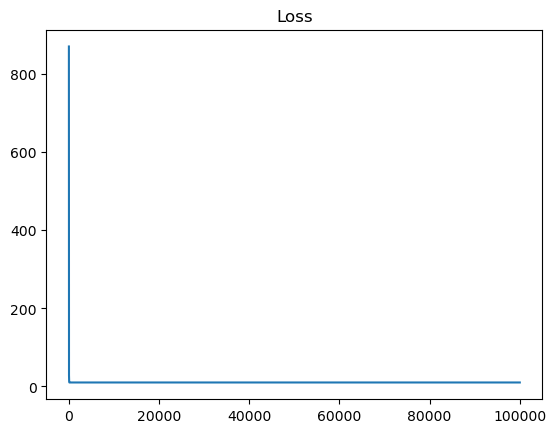

[[0.03621256]
 [1.13585468]
 [0.22067338]
 [1.50989101]
 [0.24862752]
 [0.        ]
 [0.86219682]
 [0.41180549]
 [0.        ]
 [0.        ]
 [0.09600414]
 [0.        ]
 [0.        ]
 [0.74629282]
 [0.70342982]
 [0.63503466]
 [0.72041065]
 [0.43809832]
 [0.67040968]
 [0.        ]
 [0.10958348]
 [0.79865225]
 [0.        ]
 [0.        ]
 [0.95564716]
 [0.87372812]
 [0.86592593]
 [0.11268195]
 [1.31675997]
 [0.        ]
 [0.87599962]
 [0.        ]
 [1.02626284]
 [0.69387657]
 [0.87691349]
 [0.        ]
 [0.45386983]
 [0.52025525]
 [0.32067257]
 [0.29851047]
 [0.0067246 ]
 [0.15395318]
 [0.21608374]
 [0.        ]
 [0.        ]
 [0.84549679]
 [0.40061907]
 [0.59388548]
 [0.19282674]
 [0.24744032]
 [0.09575695]
 [0.72721254]
 [1.34703102]
 [0.2912681 ]
 [0.81606278]
 [0.07220306]
 [0.47817243]
 [0.69964685]
 [0.23172183]
 [1.01224912]
 [0.41586844]
 [0.        ]
 [0.59106958]
 [0.        ]
 [0.1475491 ]
 [0.4986458 ]
 [0.71847403]
 [0.64266701]
 [0.        ]
 [0.7062715 ]
 [0.89845264]
 [0.96

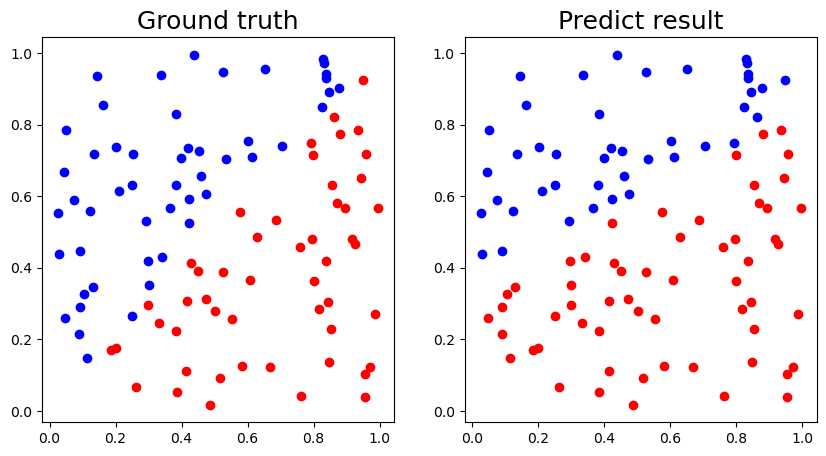

In [54]:
loss1 = Traning_and_Test(NN_relu, generate_linear, lr=0.001)

epoch 0, loss: 37.670795755878984
epoch 5000, loss: 24.824177507499137
epoch 10000, loss: 4.796133203985007
epoch 15000, loss: 2.0316449208601672
epoch 20000, loss: 1.3455857544538028
epoch 25000, loss: 0.9996052274816055
epoch 30000, loss: 0.7924843875845929
epoch 35000, loss: 0.6565281234032306
epoch 40000, loss: 0.5611700081504309
epoch 45000, loss: 0.4906734197551649
epoch 50000, loss: 0.4362605901318968
epoch 55000, loss: 0.39274301229849584
epoch 60000, loss: 0.356908548506656
epoch 65000, loss: 0.32668990148953225
epoch 70000, loss: 0.30071118252369705
epoch 75000, loss: 0.27802898085687905
epoch 80000, loss: 0.25797857458220785
epoch 85000, loss: 0.24007946480495923
epoch 90000, loss: 0.2239756699329552
epoch 95000, loss: 0.20939707312814831
epoch 100000, loss: 0.19613388971390922


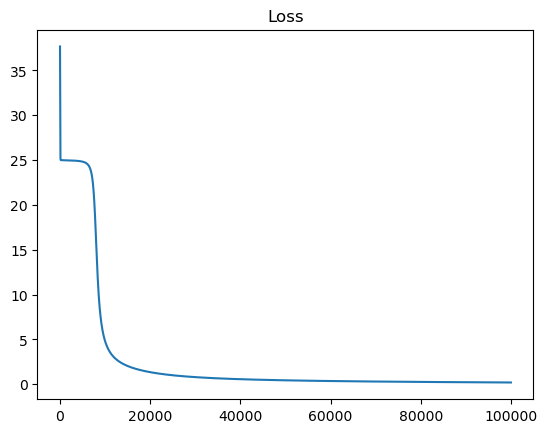

[[9.99872428e-01]
 [1.20753120e-05]
 [9.99954856e-01]
 [1.58897483e-05]
 [9.99926197e-01]
 [2.20018782e-05]
 [9.18942951e-04]
 [1.28146136e-05]
 [9.99962123e-01]
 [1.27578192e-05]
 [2.64806975e-03]
 [2.78061967e-04]
 [9.99958332e-01]
 [9.99968505e-01]
 [9.99960990e-01]
 [9.99963685e-01]
 [6.11511077e-05]
 [9.40574032e-01]
 [1.02655424e-02]
 [3.58207999e-05]
 [9.99966001e-01]
 [3.48181631e-04]
 [9.99961006e-01]
 [1.13825185e-05]
 [1.22672825e-05]
 [1.79727928e-05]
 [9.99951996e-01]
 [3.92322070e-05]
 [9.99702790e-01]
 [9.99956049e-01]
 [9.99966552e-01]
 [1.26244412e-05]
 [2.44867371e-02]
 [1.65311769e-05]
 [1.33012356e-04]
 [1.24478284e-05]
 [9.99916034e-01]
 [9.99970328e-01]
 [9.99968874e-01]
 [9.99962819e-01]
 [2.75222331e-05]
 [9.99968979e-01]
 [2.36476446e-05]
 [6.94263560e-01]
 [9.98897105e-01]
 [9.99970800e-01]
 [2.61484958e-05]
 [8.60243776e-01]
 [9.99910263e-01]
 [2.43834737e-05]
 [9.99958797e-01]
 [1.14337153e-05]
 [9.99970147e-01]
 [9.99972106e-01]
 [1.81100395e-05]
 [9.999511

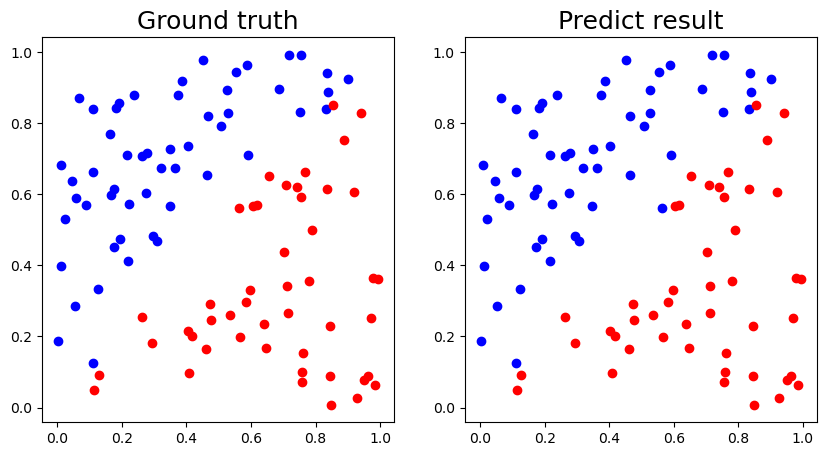

In [55]:
loss2 = Traning_and_Test(NN1, generate_linear, lr=0.001)

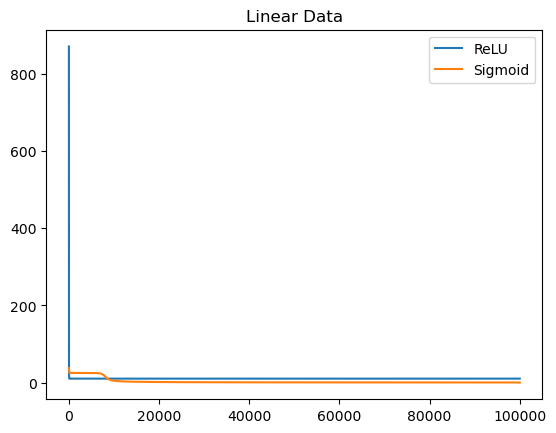

In [56]:
loss_cmp(loss1, loss2, 'ReLU', 'Sigmoid', 'Linear Data')

epoch 0, loss: 49.50950999760205
epoch 5000, loss: 6.062992177061362
epoch 10000, loss: 6.062992125984332
epoch 15000, loss: 6.062992125984253
epoch 20000, loss: 6.062992125984252
epoch 25000, loss: 6.062992125984252
epoch 30000, loss: 6.062992125984254
epoch 35000, loss: 6.062992125984252
epoch 40000, loss: 6.062992125984252
epoch 45000, loss: 6.062992125984252
epoch 50000, loss: 6.062992125984252
epoch 55000, loss: 6.062992125984252
epoch 60000, loss: 6.062992125984252
epoch 65000, loss: 6.062992125984252
epoch 70000, loss: 6.062992125984252
epoch 75000, loss: 6.062992125984252
epoch 80000, loss: 6.062992125984252
epoch 85000, loss: 6.062992125984252
epoch 90000, loss: 6.062992125984252
epoch 95000, loss: 6.062992125984252
epoch 100000, loss: 6.062992125984252


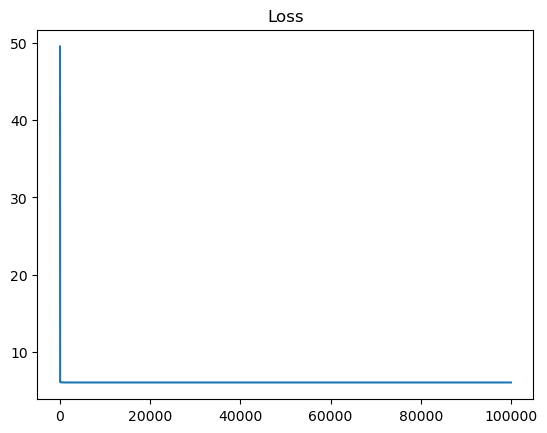

[[0.        ]
 [0.39370079]
 [0.07874016]
 [0.39370079]
 [0.15748031]
 [0.39370079]
 [0.23622047]
 [0.39370079]
 [0.31496063]
 [0.39370079]
 [0.39370079]
 [0.47244094]
 [0.39370079]
 [0.5511811 ]
 [0.39370079]
 [0.62992126]
 [0.39370079]
 [0.70866142]
 [0.39370079]
 [0.78740157]
 [0.39370079]]
Accuracy: 0.3333333333333333


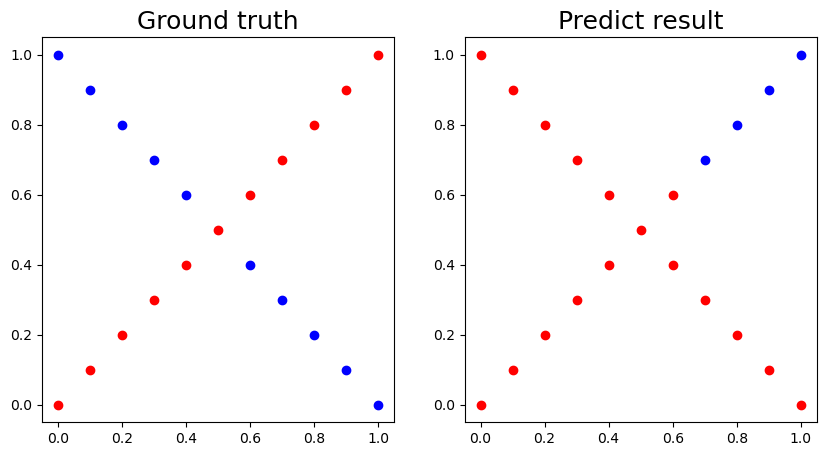

epoch 0, loss: 7.261784042952952
epoch 5000, loss: 5.2386878935314405
epoch 10000, loss: 5.238382335482579
epoch 15000, loss: 5.238107714625402
epoch 20000, loss: 5.237788479783701
epoch 25000, loss: 5.237312572092497
epoch 30000, loss: 5.236411081347367
epoch 35000, loss: 5.234146644341912
epoch 40000, loss: 5.224670414739588
epoch 45000, loss: 5.069496428786681
epoch 50000, loss: 2.268663616628846
epoch 55000, loss: 0.43195994129955917
epoch 60000, loss: 0.09325430027326992
epoch 65000, loss: 0.03715220047077492
epoch 70000, loss: 0.020851530718048832
epoch 75000, loss: 0.0138457792563406
epoch 80000, loss: 0.01011673420453143
epoch 85000, loss: 0.007855308691780916
epoch 90000, loss: 0.006359285634884035
epoch 95000, loss: 0.0053064639024014175
epoch 100000, loss: 0.004530576465695031


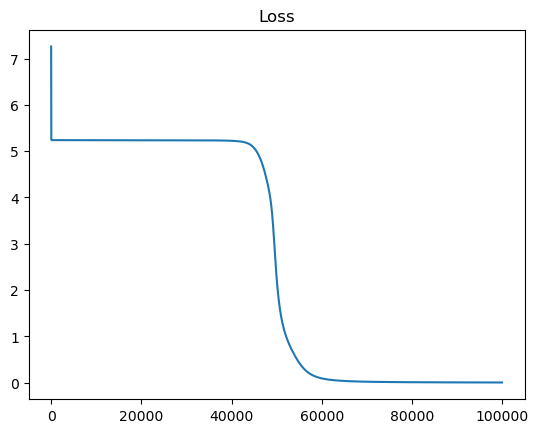

[[1.07068435e-04]
 [9.99962730e-01]
 [6.53612297e-04]
 [9.99958734e-01]
 [4.31640106e-03]
 [9.99947406e-01]
 [1.65571199e-02]
 [9.99851739e-01]
 [2.88746903e-02]
 [9.64870757e-01]
 [2.63858423e-02]
 [1.62743275e-02]
 [9.66687325e-01]
 [8.47670886e-03]
 [9.99851735e-01]
 [4.34980605e-03]
 [9.99923279e-01]
 [2.38616408e-03]
 [9.99915152e-01]
 [1.44143393e-03]
 [9.99891469e-01]]
Accuracy: 1.0


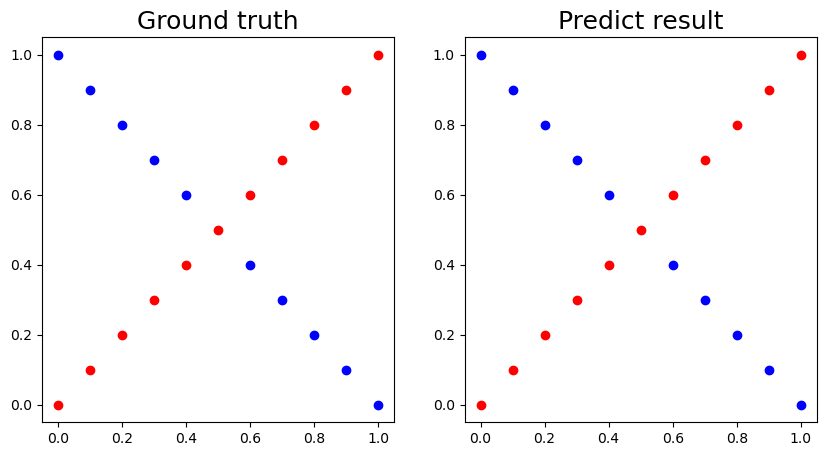

In [59]:
loss1 = Traning_and_Test(NN_relu, generate_XOR_easy, lr=0.001)
loss2 = Traning_and_Test(NN1, generate_XOR_easy, lr=0.01)

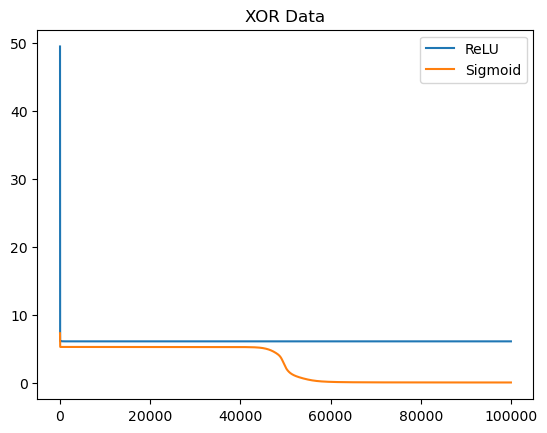

In [60]:
loss_cmp(loss1, loss2, 'ReLU', 'Sigmoid', 'XOR Data')

In [62]:
class NN_adagrad:
    def __init__(self, X, Y, n_hidden=4, lr=0.1):
        self.X = X
        self.Y = Y
        self.n_hidden = n_hidden
        self.weights1 = Linear(self.X.shape[1], self.n_hidden)
        self.weights2 = Linear(self.n_hidden, self.n_hidden)
        self.weights3 = Linear(self.n_hidden, 1)
        self.sigmoid1 = Sigmoid()
        self.sigmoid2 = Sigmoid()
        self.sigmoid3 = Sigmoid()
        self.lr = lr
        self.optimizer = Adagrad([self.weights1, self.weights2, self.weights3], self.lr)

    def forward(self, input):
        self.a1 = self.weights1.forward(input)
        self.b1 = self.sigmoid1.forward(self.a1)
        self.a2 = self.weights2.forward(self.b1)
        self.b2 = self.sigmoid2.forward(self.a2)
        self.a3 = self.weights3.forward(self.b2)
        self.out = self.sigmoid3.forward(self.a3)
        return self.out
    
    def train(self):
        y = self.forward(self.X)
        loss = np.sum((y-self.Y)**2)
        
        # Backpropagation
        dloss_dy = 2*(y-self.Y)
        dou_da3 = self.sigmoid3.backward(dloss_dy)
        da3_db2 = self.weights3.backward(dou_da3)
        db2_da2 = self.sigmoid2.backward(da3_db2)
        da2_db1 = self.weights2.backward(db2_da2)
        db1_da1 = self.sigmoid1.backward(da2_db1)
        da1_dw1 = self.weights1.backward(db1_da1)
        
        # Update Weights
        self.optimizer.step()

        return loss
    
class NN_momentum:
    def __init__(self, X, Y, n_hidden=4, lr=0.1):
        self.X = X
        self.Y = Y
        self.n_hidden = n_hidden
        self.weights1 = Linear(self.X.shape[1], self.n_hidden)
        self.weights2 = Linear(self.n_hidden, self.n_hidden)
        self.weights3 = Linear(self.n_hidden, 1)
        self.sigmoid1 = Sigmoid()
        self.sigmoid2 = Sigmoid()
        self.sigmoid3 = Sigmoid()
        self.lr = lr
        self.optimizer = Momentum([self.weights1, self.weights2, self.weights3], self.lr)

    def forward(self, input):
        self.a1 = self.weights1.forward(input)
        self.b1 = self.sigmoid1.forward(self.a1)
        self.a2 = self.weights2.forward(self.b1)
        self.b2 = self.sigmoid2.forward(self.a2)
        self.a3 = self.weights3.forward(self.b2)
        self.out = self.sigmoid3.forward(self.a3)
        return self.out
    
    def train(self):
        y = self.forward(self.X)
        loss = np.sum((y-self.Y)**2)
        
        # Backpropagation
        dloss_dy = 2*(y-self.Y)
        dou_da3 = self.sigmoid3.backward(dloss_dy)
        da3_db2 = self.weights3.backward(dou_da3)
        db2_da2 = self.sigmoid2.backward(da3_db2)
        da2_db1 = self.weights2.backward(db2_da2)
        db1_da1 = self.sigmoid1.backward(da2_db1)
        da1_dw1 = self.weights1.backward(db1_da1)
        
        # Update Weights
        self.optimizer.step()

        return loss

epoch 0, loss: 30.484836653687424
epoch 5000, loss: 0.5887329505338736
epoch 10000, loss: 0.5316775913454483
epoch 15000, loss: 0.8042324463956951
epoch 20000, loss: 0.02116284513687754
epoch 25000, loss: 0.007101581954804135
epoch 30000, loss: 0.003996964469382809
epoch 35000, loss: 0.002697825633489991
epoch 40000, loss: 0.0020031583714593317
epoch 45000, loss: 0.0015771933807602603
epoch 50000, loss: 0.0012920010476791875
epoch 55000, loss: 0.0010889996588737579
epoch 60000, loss: 0.0009378322223687523
epoch 65000, loss: 0.0008212973560756491
epoch 70000, loss: 0.0007289647026251713
epoch 75000, loss: 0.000654163833689905
epoch 80000, loss: 0.0005924416402373173
epoch 85000, loss: 0.0005407181234725702
epoch 90000, loss: 0.0004967987831396714
epoch 95000, loss: 0.00045908001967295603
epoch 100000, loss: 0.0004263642381054293


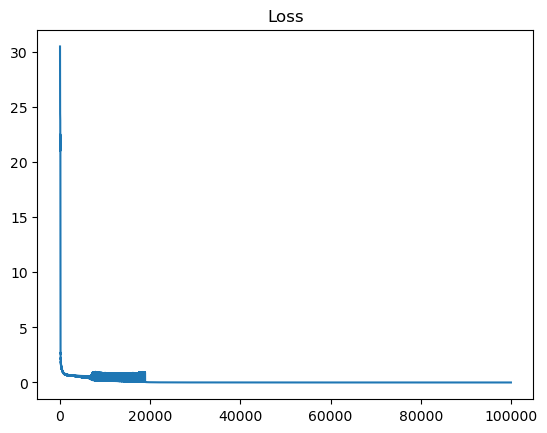

[[1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [5.02395668e-09]
 [5.39081657e-09]
 [1.79958691e-07]
 [1.00000000e+00]
 [4.99415813e-09]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [4.94966777e-09]
 [1.42874190e-07]
 [5.03185000e-05]
 [1.13776994e-08]
 [1.00000000e+00]
 [4.82488028e-09]
 [4.86859340e-09]
 [1.00000000e+00]
 [1.00000000e+00]
 [4.80589006e-09]
 [4.83599747e-09]
 [4.82318030e-09]
 [1.10108798e-08]
 [1.00000000e+00]
 [4.76173229e-09]
 [4.84671906e-09]
 [4.82557536e-09]
 [6.50939433e-09]
 [6.12777587e-09]
 [5.06821267e-09]
 [4.96440966e-09]
 [4.81823129e-09]
 [9.99999997e-01]
 [1.00000000e+00]
 [4.82741396e-09]
 [9.99999982e-01]
 [1.00000000e+00]
 [4.85330098e-09]
 [1.00000000e+00]
 [1.00000000e+00]
 [4.78140487e-09]
 [1.00000000e+00]
 [5.13241991e-09]
 [4.84285669e-09]
 [4.88794061e-09]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [5.59599873e-09]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [4.76688385e-09]
 [4.75906725e-09]
 [1.000000

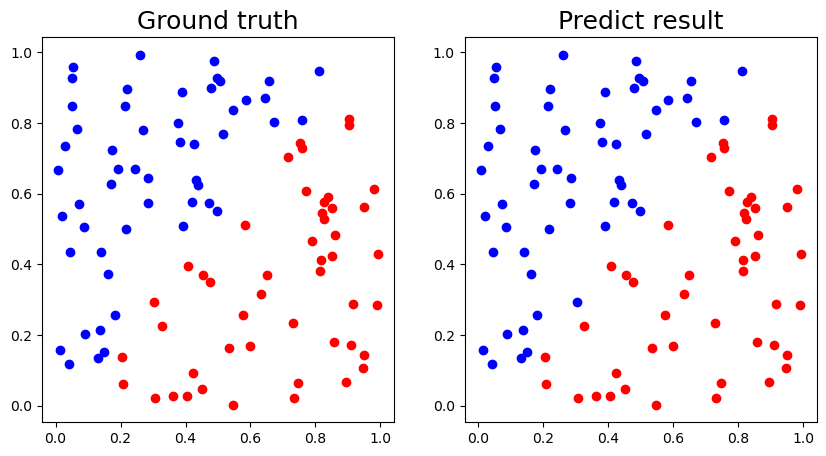

epoch 0, loss: 37.43787269354905
epoch 5000, loss: 0.25243902830543313
epoch 10000, loss: 0.09603594766995625
epoch 15000, loss: 0.048810652553379685
epoch 20000, loss: 0.029851465509181663
epoch 25000, loss: 0.020510275133298752
epoch 30000, loss: 0.015205064512623214
epoch 35000, loss: 0.01187728447548457
epoch 40000, loss: 0.009634398182346111
epoch 45000, loss: 0.008039175874095474
epoch 50000, loss: 0.006856483311434795
epoch 55000, loss: 0.005950304578967752
epoch 60000, loss: 0.005237240260159853
epoch 65000, loss: 0.004663667425884502
epoch 70000, loss: 0.004193724862383881
epoch 75000, loss: 0.0038026227269260175
epoch 80000, loss: 0.0034727343258245725
epoch 85000, loss: 0.0031912179835648625
epoch 90000, loss: 0.002948518155999165
epoch 95000, loss: 0.002737391344773105
epoch 100000, loss: 0.00255225582304267


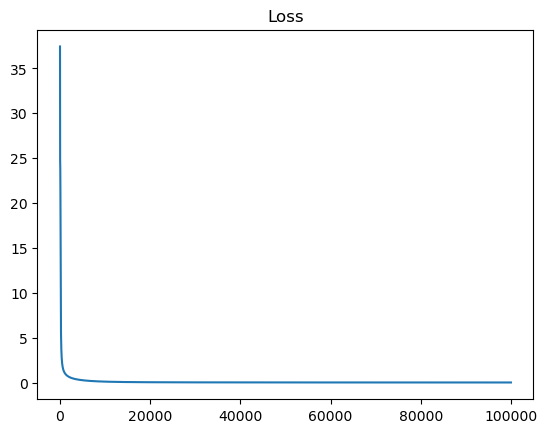

[[3.35939767e-05]
 [9.99946063e-01]
 [9.99946064e-01]
 [9.99946045e-01]
 [9.99946063e-01]
 [9.99945976e-01]
 [3.43169030e-05]
 [9.99945887e-01]
 [9.99696953e-01]
 [9.99940338e-01]
 [9.99946037e-01]
 [3.35833766e-05]
 [9.99942485e-01]
 [3.35784524e-05]
 [9.99879578e-01]
 [9.99946061e-01]
 [9.99946045e-01]
 [3.35771171e-05]
 [9.98611066e-04]
 [3.35789263e-05]
 [3.40186299e-05]
 [2.84070747e-04]
 [9.99946057e-01]
 [7.31337756e-01]
 [8.52080355e-03]
 [3.35774053e-05]
 [9.99945956e-01]
 [3.35802532e-05]
 [9.99946048e-01]
 [3.35782274e-05]
 [9.99946065e-01]
 [9.99945590e-01]
 [3.35777911e-05]
 [9.99945888e-01]
 [3.42316688e-05]
 [9.99946062e-01]
 [3.35769395e-05]
 [9.99945733e-01]
 [3.35793474e-05]
 [3.35799553e-05]
 [9.99945858e-01]
 [9.99945992e-01]
 [9.99946017e-01]
 [9.99945996e-01]
 [3.38562051e-05]
 [9.99946050e-01]
 [3.38218261e-05]
 [9.99946065e-01]
 [9.99946033e-01]
 [9.99946065e-01]
 [3.45797854e-05]
 [6.79968975e-05]
 [9.99548714e-01]
 [4.46506887e-05]
 [9.99945404e-01]
 [9.999460

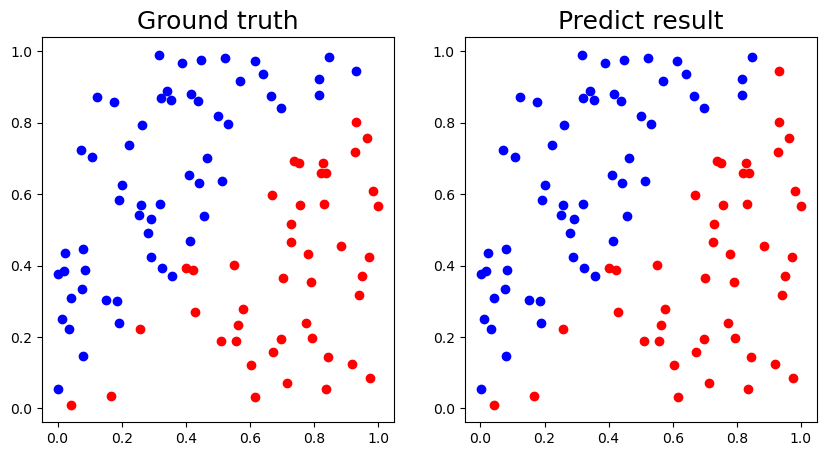

epoch 0, loss: 29.5343448749832
epoch 5000, loss: 11.75410118826063
epoch 10000, loss: 11.751807644615955
epoch 15000, loss: 11.751125363873076
epoch 20000, loss: 11.750805592311707
epoch 25000, loss: 11.75062224725814
epoch 30000, loss: 11.750504214300209
epoch 35000, loss: 11.7504222603516
epoch 40000, loss: 11.750362239327082
epoch 45000, loss: 11.750316501361446
epoch 50000, loss: 11.750280560614474
epoch 55000, loss: 11.750251618848418
epoch 60000, loss: 11.750227843198468
epoch 65000, loss: 11.75020798465886
epoch 70000, loss: 11.750191163757671
epoch 75000, loss: 11.750176743919198
epoch 80000, loss: 11.750164253411892
epoch 85000, loss: 11.750153335485692
epoch 90000, loss: 11.750143715520217
epoch 95000, loss: 11.750135178792089
epoch 100000, loss: 11.75012755507022


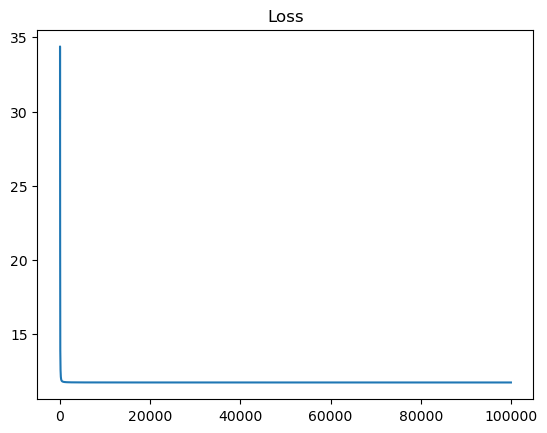

[[0.50000003]
 [0.99999972]
 [0.50000004]
 [0.99999978]
 [1.        ]
 [1.        ]
 [0.99999989]
 [0.50000003]
 [0.50000006]
 [0.50000002]
 [0.50000008]
 [0.99999998]
 [0.50000002]
 [0.50000002]
 [0.50000003]
 [1.        ]
 [0.99999996]
 [0.50000002]
 [0.50000011]
 [0.99999997]
 [0.50000002]
 [1.        ]
 [0.9999997 ]
 [0.50000363]
 [0.50000004]
 [1.        ]
 [0.50000002]
 [0.99999985]
 [0.50505216]
 [0.50628997]
 [0.99999999]
 [0.61417328]
 [0.99999981]
 [0.50000019]
 [0.50000002]
 [0.99999975]
 [0.9999998 ]
 [0.50000002]
 [0.99999557]
 [0.50000002]
 [0.50000002]
 [0.9999997 ]
 [0.50000002]
 [1.        ]
 [0.99999995]
 [0.99999999]
 [1.        ]
 [0.99999999]
 [0.99999986]
 [0.50000012]
 [1.        ]
 [1.        ]
 [0.99999977]
 [0.63422463]
 [0.99999997]
 [0.50000151]
 [0.99999999]
 [0.50000002]
 [0.50000002]
 [1.        ]
 [1.        ]
 [0.99999978]
 [0.50000002]
 [0.50000002]
 [0.50000003]
 [1.        ]
 [0.99999981]
 [0.50000003]
 [0.99999999]
 [1.        ]
 [0.99999999]
 [1.  

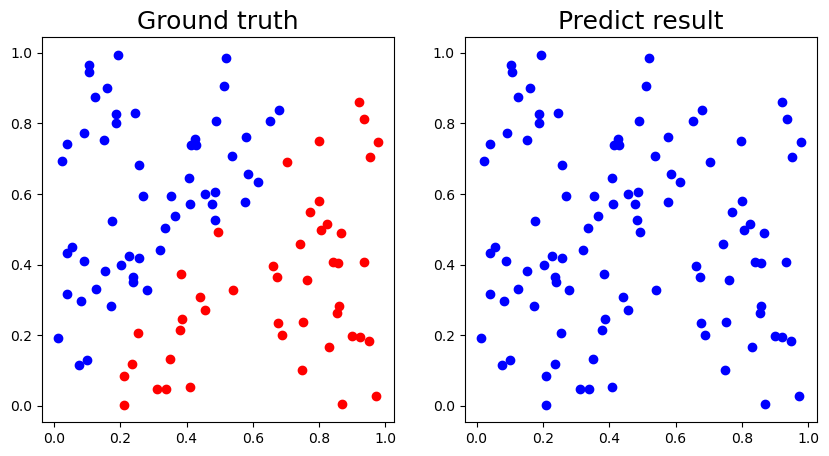

In [66]:
loss1 = Traning_and_Test(NN1, generate_linear, lr=0.1)
loss2 = Traning_and_Test(NN_adagrad, generate_linear, lr=0.1)
loss3 = Traning_and_Test(NN_momentum, generate_linear, lr=0.1)

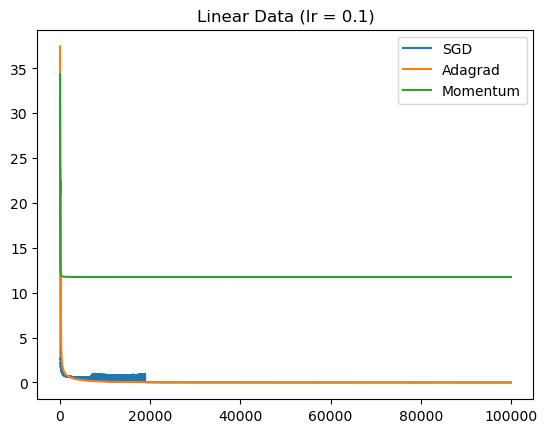

In [67]:
plt.title('Linear Data (lr = 0.1)')
plt.plot(loss1, label='SGD')
plt.plot(loss2, label='Adagrad')
plt.plot(loss3, label='Momentum')
plt.legend()
plt.show()

epoch 0, loss: 8.303330143910605
epoch 5000, loss: 0.06261977388730629
epoch 10000, loss: 0.0034934384192771522
epoch 15000, loss: 0.0015605330126510168
epoch 20000, loss: 0.0009710873389061021
epoch 25000, loss: 0.0006942318792344792
epoch 30000, loss: 0.0005356574983719841
epoch 35000, loss: 0.0004337256918008583
epoch 40000, loss: 0.00036305222828143536
epoch 45000, loss: 0.0003113560725637113
epoch 50000, loss: 0.0002720019723343136
epoch 55000, loss: 0.00024110344128117618
epoch 60000, loss: 0.00021623891744260455
epoch 65000, loss: 0.00019582401458689011
epoch 70000, loss: 0.00017878015888553054
epoch 75000, loss: 0.00016434859597336788
epoch 80000, loss: 0.00015198059220019195
epoch 85000, loss: 0.00014126982110706848
epoch 90000, loss: 0.00013190920645555915
epoch 95000, loss: 0.00012366251168371775
epoch 100000, loss: 0.00011634512768491148


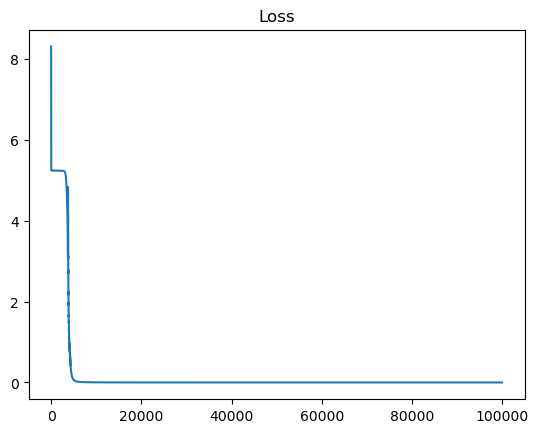

[[5.40161969e-05]
 [9.99961758e-01]
 [2.28462629e-04]
 [9.99969987e-01]
 [1.04792098e-03]
 [9.99974255e-01]
 [3.13046211e-03]
 [9.99965223e-01]
 [4.69882761e-03]
 [9.94606840e-01]
 [3.89151995e-03]
 [2.27449636e-03]
 [9.94348192e-01]
 [1.17755686e-03]
 [9.99968621e-01]
 [6.23675541e-04]
 [9.99982817e-01]
 [3.60782723e-04]
 [9.99984944e-01]
 [2.31589969e-04]
 [9.99985904e-01]]
Accuracy: 1.0


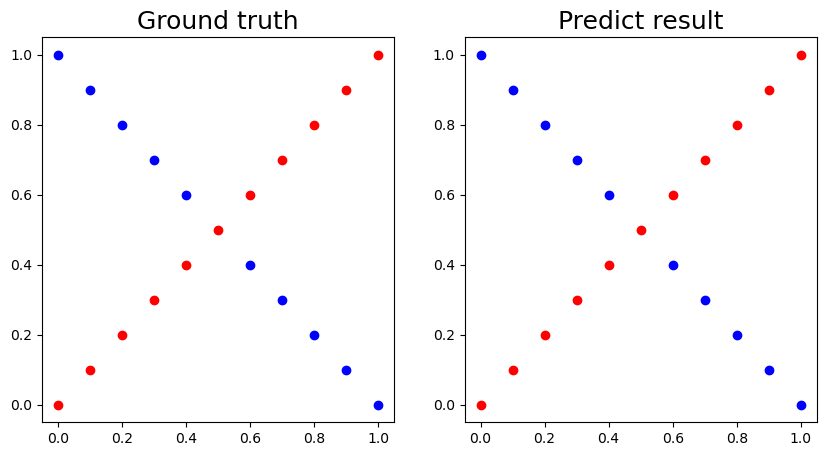

epoch 0, loss: 7.967611394688962
epoch 5000, loss: 0.45132422385953547
epoch 10000, loss: 0.24915242189831224
epoch 15000, loss: 0.00664230100750253
epoch 20000, loss: 0.002095875112757522
epoch 25000, loss: 0.0015099104253819492
epoch 30000, loss: 0.0012550491307110414
epoch 35000, loss: 0.0011041786701023546
epoch 40000, loss: 0.00100049186056961
epoch 45000, loss: 0.0009226294741031406
epoch 50000, loss: 0.0008606712749058762
epoch 55000, loss: 0.0008093500730017878
epoch 60000, loss: 0.0007655907226469965
epoch 65000, loss: 0.0007274636080290273
epoch 70000, loss: 0.0006936868472312496
epoch 75000, loss: 0.0006633686210264312
epoch 80000, loss: 0.0006358645472047909
epoch 85000, loss: 0.0006106942569296332
epoch 90000, loss: 0.0005874902709005619
epoch 95000, loss: 0.0005659653861515978
epoch 100000, loss: 0.0005458911278028491


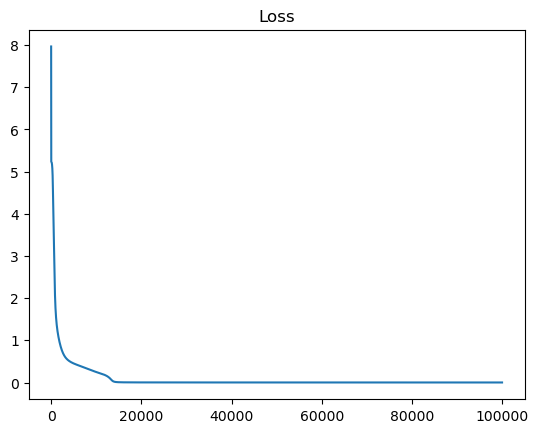

[[0.00275912]
 [0.99422028]
 [0.00441043]
 [0.99731528]
 [0.00572991]
 [0.9977144 ]
 [0.0057124 ]
 [0.99774798]
 [0.00541261]
 [0.99430494]
 [0.00506606]
 [0.00474568]
 [0.99171643]
 [0.00446397]
 [0.99389704]
 [0.00422036]
 [0.99393088]
 [0.00401329]
 [0.99380963]
 [0.00384079]
 [0.99344873]]
Accuracy: 1.0


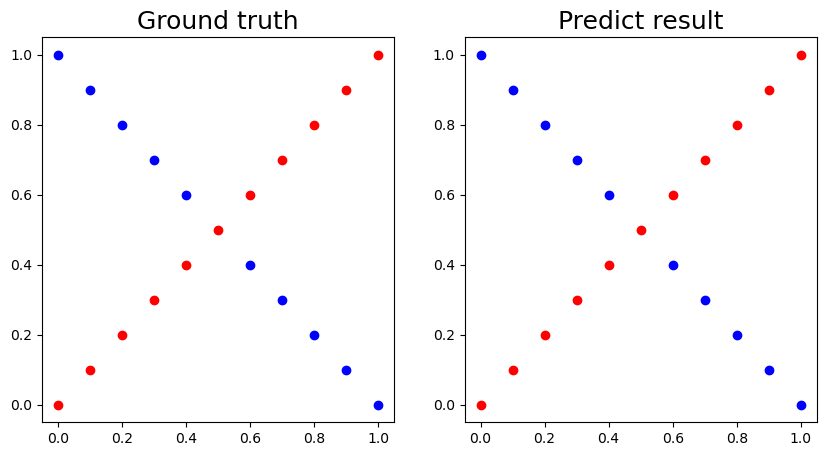

epoch 0, loss: 7.266414078674965
epoch 5000, loss: 4.8256813510552306
epoch 10000, loss: 4.804415614560117
epoch 15000, loss: 4.79291195921914
epoch 20000, loss: 4.785073223405989
epoch 25000, loss: 4.779151652721393
epoch 30000, loss: 4.774405959570208
epoch 35000, loss: 4.770453607147788
epoch 40000, loss: 4.767071809291614
epoch 45000, loss: 4.764119616764158
epoch 50000, loss: 4.76150229554219
epoch 55000, loss: 4.759153161723377
epoch 60000, loss: 4.757023530810404
epoch 65000, loss: 4.7550767919841945
epoch 70000, loss: 4.7532847317489795
epoch 75000, loss: 4.751625155627739
epoch 80000, loss: 4.750080294769305
epoch 85000, loss: 4.748635706194391
epoch 90000, loss: 4.747279494073273
epoch 95000, loss: 4.746001745909916
epoch 100000, loss: 4.744794116267308


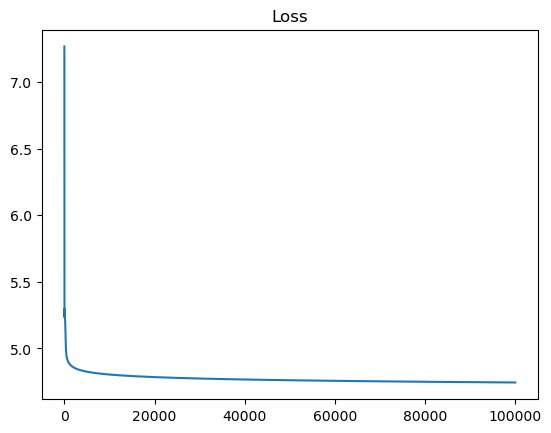

[[0.01702474]
 [0.4632718 ]
 [0.17175483]
 [0.4632718 ]
 [0.33758702]
 [0.4632718 ]
 [0.41537828]
 [0.4632718 ]
 [0.44830088]
 [0.4632718 ]
 [0.4632718 ]
 [0.47069692]
 [0.4632718 ]
 [0.47464402]
 [0.4632718 ]
 [0.47684727]
 [0.4632718 ]
 [0.47811754]
 [0.4632718 ]
 [0.47886522]
 [0.4632718 ]]
Accuracy: 0.5238095238095238


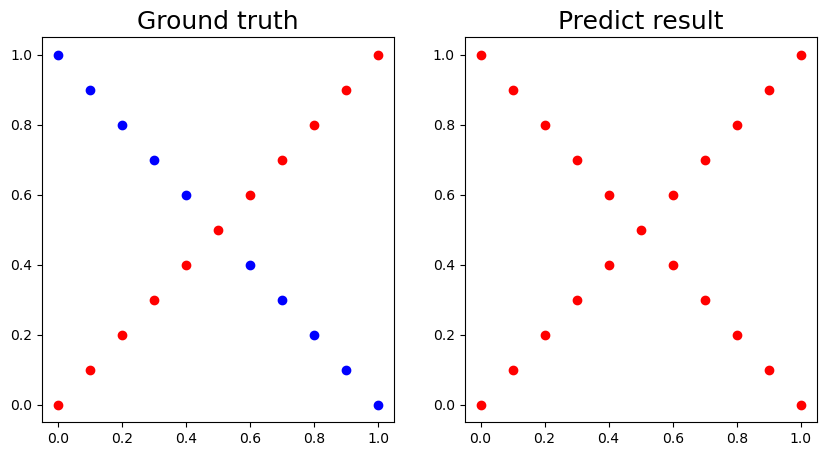

In [68]:
loss1 = Traning_and_Test(NN1, generate_XOR_easy, lr=0.1)
loss2 = Traning_and_Test(NN_adagrad, generate_XOR_easy, lr=0.1)
loss3 = Traning_and_Test(NN_momentum, generate_XOR_easy, lr=0.1)

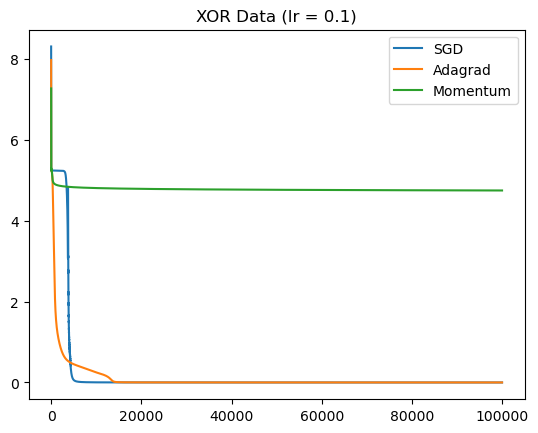

In [69]:
plt.title('XOR Data (lr = 0.1)')
plt.plot(loss1, label='SGD')
plt.plot(loss2, label='Adagrad')
plt.plot(loss3, label='Momentum')
plt.legend()
plt.show()

epoch 0, loss: 43.96769173924146
epoch 5000, loss: 24.85307441291353
epoch 10000, loss: 6.343956924135204
epoch 15000, loss: 2.089989221653483
epoch 20000, loss: 1.4793982076530632
epoch 25000, loss: 1.1429565278438039
epoch 30000, loss: 0.9199243135967531
epoch 35000, loss: 0.7662663115748666
epoch 40000, loss: 0.6577064424469402
epoch 45000, loss: 0.5785598771137989
epoch 50000, loss: 0.5187557144265627
epoch 55000, loss: 0.47191509182156843
epoch 60000, loss: 0.4339911457719093
epoch 65000, loss: 0.4023815281364436
epoch 70000, loss: 0.3753785336953541
epoch 75000, loss: 0.35183511002382695
epoch 80000, loss: 0.3309620600119859
epoch 85000, loss: 0.31220355953372764
epoch 90000, loss: 0.2951594234674655
epoch 95000, loss: 0.2795355552102139
epoch 100000, loss: 0.265111655666297


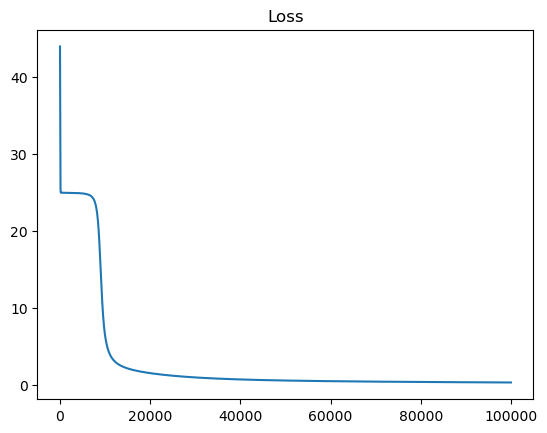

[[9.99840487e-01]
 [9.99932511e-01]
 [9.99540548e-01]
 [2.57741402e-05]
 [2.63718428e-04]
 [3.68458832e-05]
 [2.00784562e-05]
 [9.99941397e-01]
 [2.43184389e-05]
 [9.99924860e-01]
 [9.99947769e-01]
 [9.99943129e-01]
 [9.99552184e-01]
 [1.80235634e-04]
 [4.00681619e-05]
 [1.98199482e-05]
 [6.11508510e-05]
 [9.99948035e-01]
 [9.99915244e-01]
 [9.99936944e-01]
 [9.99945497e-01]
 [9.99925441e-01]
 [6.82792937e-05]
 [1.31665749e-03]
 [9.97675277e-01]
 [2.36489645e-05]
 [3.17412532e-05]
 [9.99943409e-01]
 [3.44282648e-05]
 [9.99926966e-01]
 [2.16755548e-05]
 [8.77127029e-01]
 [9.99928438e-01]
 [9.99931300e-01]
 [9.97812959e-01]
 [9.99892726e-01]
 [3.56067532e-05]
 [9.99939852e-01]
 [9.99940348e-01]
 [1.77121163e-02]
 [9.99810165e-01]
 [8.48974483e-01]
 [3.40116840e-05]
 [2.60481061e-05]
 [9.99939101e-01]
 [9.99948065e-01]
 [2.04442842e-05]
 [9.99919777e-01]
 [9.99802234e-01]
 [1.96862481e-03]
 [9.74293756e-05]
 [2.09460072e-05]
 [5.29192445e-03]
 [5.27778946e-05]
 [9.99805494e-01]
 [2.108370

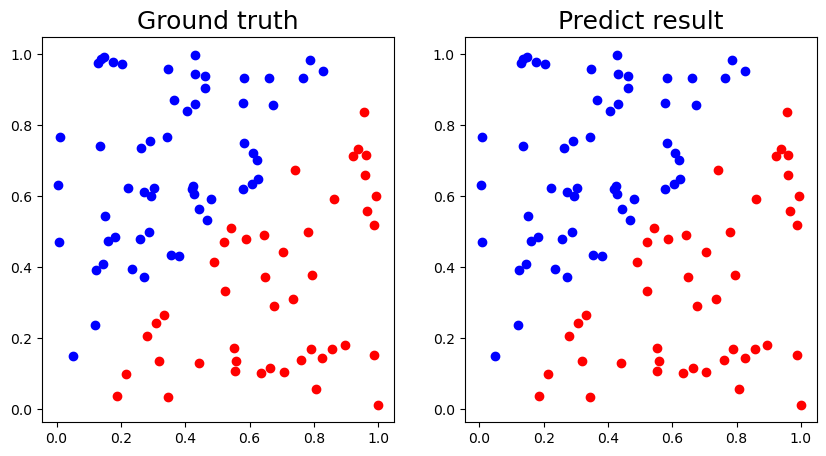

epoch 0, loss: 31.25001677187592
epoch 5000, loss: 27.31052338040621
epoch 10000, loss: 26.278391009711637
epoch 15000, loss: 25.7314444902582
epoch 20000, loss: 25.41118942839739
epoch 25000, loss: 25.214152909251222
epoch 30000, loss: 25.088635226901133
epoch 35000, loss: 25.00622435255273
epoch 40000, loss: 24.950348140335926
epoch 45000, loss: 24.910950698944557
epoch 50000, loss: 24.88178516178295
epoch 55000, loss: 24.858913034856094
epoch 60000, loss: 24.83982443473676
epoch 65000, loss: 24.822904849762576
epoch 70000, loss: 24.807105244047055
epoch 75000, loss: 24.791735277969522
epoch 80000, loss: 24.77633255990701
epoch 85000, loss: 24.760579454410944
epoch 90000, loss: 24.744249893443225
epoch 95000, loss: 24.727175233008726
epoch 100000, loss: 24.70922225422454


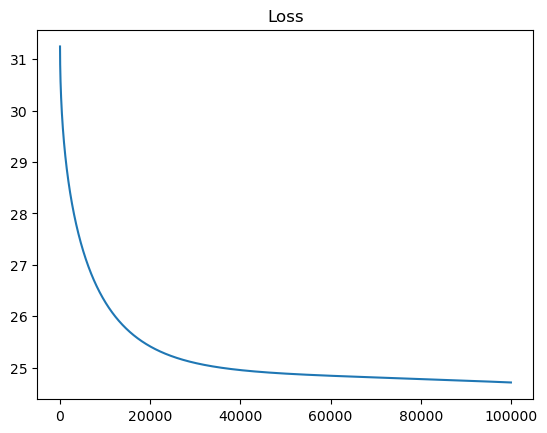

[[0.51923809]
 [0.52558034]
 [0.52061183]
 [0.5253494 ]
 [0.5252899 ]
 [0.51758597]
 [0.51822697]
 [0.5205078 ]
 [0.5168424 ]
 [0.5231163 ]
 [0.52066791]
 [0.52319415]
 [0.52407953]
 [0.52328928]
 [0.51903283]
 [0.52617514]
 [0.52468188]
 [0.52280514]
 [0.52530222]
 [0.52062984]
 [0.52408865]
 [0.51981925]
 [0.51827982]
 [0.51843499]
 [0.52277546]
 [0.5181947 ]
 [0.51887198]
 [0.51981746]
 [0.52472085]
 [0.51456313]
 [0.51910312]
 [0.52043123]
 [0.51707597]
 [0.51912948]
 [0.51820735]
 [0.52058126]
 [0.52245012]
 [0.51974565]
 [0.52141696]
 [0.52317776]
 [0.52008984]
 [0.5218375 ]
 [0.52440552]
 [0.51909459]
 [0.51764312]
 [0.52478001]
 [0.51681632]
 [0.51811648]
 [0.52481438]
 [0.51886294]
 [0.51764543]
 [0.51736855]
 [0.51819127]
 [0.52580204]
 [0.51497605]
 [0.52009304]
 [0.52052544]
 [0.52272162]
 [0.51640976]
 [0.51971219]
 [0.52104754]
 [0.5162525 ]
 [0.51659845]
 [0.5226104 ]
 [0.52274776]
 [0.51916991]
 [0.52190197]
 [0.51716394]
 [0.51622677]
 [0.52084207]
 [0.5211884 ]
 [0.51

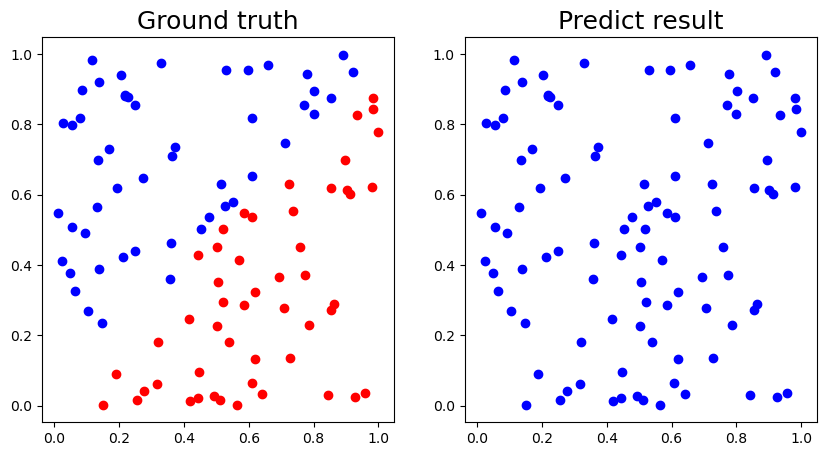

epoch 0, loss: 27.779181749787398
epoch 5000, loss: 0.2380021667194893
epoch 10000, loss: 0.07784584053866667
epoch 15000, loss: 0.042338557925627754
epoch 20000, loss: 0.02771346490316876
epoch 25000, loss: 0.0200413404129925
epoch 30000, loss: 0.015426418804106693
epoch 35000, loss: 0.012392179958534966
epoch 40000, loss: 0.01026825656630863
epoch 45000, loss: 0.008710737934116683
epoch 50000, loss: 0.007526801784796901
epoch 55000, loss: 0.00660076082853395
epoch 60000, loss: 0.005859395235466305
epoch 65000, loss: 0.005254312537708981
epoch 70000, loss: 0.004752362975237827
epoch 75000, loss: 0.004330143878448034
epoch 80000, loss: 0.003970703689124422
epoch 85000, loss: 0.00366148829106019
epoch 90000, loss: 0.0033930186963138844
epoch 95000, loss: 0.0031580149801331233
epoch 100000, loss: 0.0029508011385300428


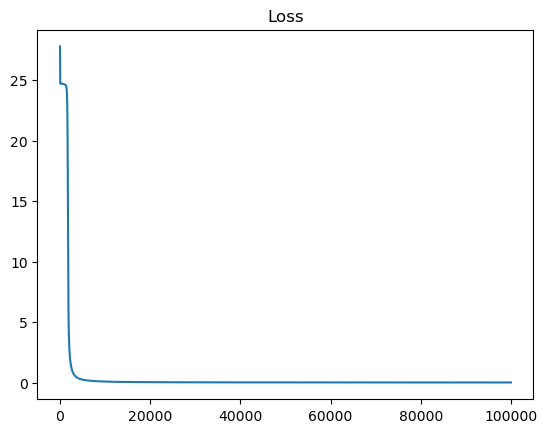

[[4.01739646e-06]
 [3.78019313e-06]
 [9.99562649e-01]
 [5.55152246e-06]
 [9.99987974e-01]
 [3.81284191e-06]
 [3.80808727e-06]
 [3.94331094e-06]
 [9.99987915e-01]
 [9.99884806e-01]
 [9.99987261e-01]
 [9.99987959e-01]
 [2.15418197e-05]
 [5.06955713e-06]
 [1.01396596e-05]
 [9.99986522e-01]
 [3.76983579e-06]
 [9.99984322e-01]
 [2.27353843e-02]
 [9.91648556e-01]
 [9.99983787e-01]
 [9.99984540e-01]
 [9.99987706e-01]
 [9.99987775e-01]
 [3.99149210e-06]
 [3.80432394e-06]
 [9.99987977e-01]
 [3.71296868e-06]
 [3.63570139e-05]
 [9.99987643e-01]
 [4.15050828e-06]
 [9.99987089e-01]
 [3.90345775e-06]
 [3.78014559e-06]
 [2.95511543e-04]
 [4.12998880e-06]
 [9.99987797e-01]
 [9.99987962e-01]
 [9.99985160e-01]
 [3.97430734e-06]
 [9.99987638e-01]
 [9.98316633e-01]
 [9.99987829e-01]
 [4.42047413e-06]
 [4.74067989e-04]
 [9.99987652e-01]
 [9.99987189e-01]
 [9.99673046e-01]
 [1.01969508e-05]
 [9.99735154e-01]
 [9.99984387e-01]
 [9.99987229e-01]
 [4.22554085e-06]
 [9.99985060e-01]
 [9.99987012e-01]
 [3.788406

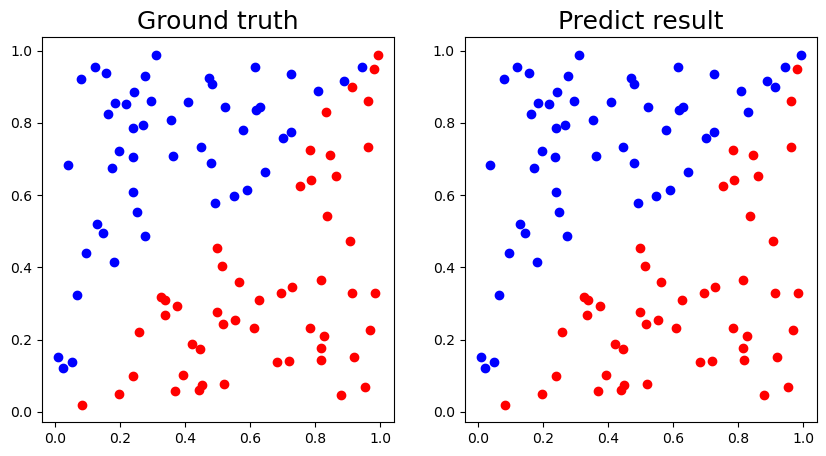

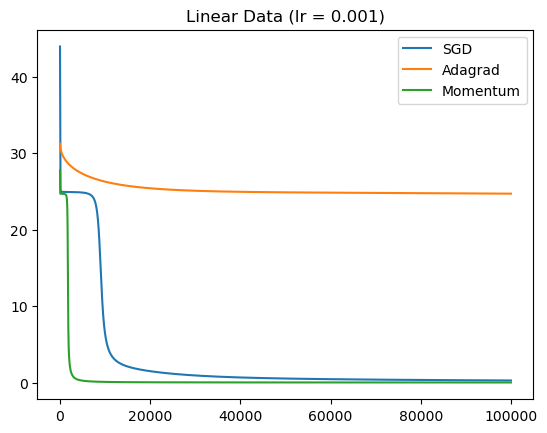

In [70]:
loss1 = Traning_and_Test(NN1, generate_linear, lr=0.001)
loss2 = Traning_and_Test(NN_adagrad, generate_linear, lr=0.001)
loss3 = Traning_and_Test(NN_momentum, generate_linear, lr=0.001)
plt.title('Linear Data (lr = 0.001)')
plt.plot(loss1, label='SGD')
plt.plot(loss2, label='Adagrad')
plt.plot(loss3, label='Momentum')
plt.legend()
plt.show()

epoch 0, loss: 8.688473379051489
epoch 5000, loss: 5.239455584965677
epoch 10000, loss: 5.239379139126365
epoch 15000, loss: 5.239308532252141
epoch 20000, loss: 5.2392431529646615
epoch 25000, loss: 5.239182455547676
epoch 30000, loss: 5.239125951603268
epoch 35000, loss: 5.239073202904348
epoch 40000, loss: 5.239023815244574
epoch 45000, loss: 5.23897743312378
epoch 50000, loss: 5.238933735136424
epoch 55000, loss: 5.238892429953951
epoch 60000, loss: 5.238853252810744
epoch 65000, loss: 5.23881596241858
epoch 70000, loss: 5.238780338246716
epoch 75000, loss: 5.238746178114783
epoch 80000, loss: 5.238713296053857
epoch 85000, loss: 5.238681520397765
epoch 90000, loss: 5.238650692072207
epoch 95000, loss: 5.238620663053886
epoch 100000, loss: 5.238591294975492


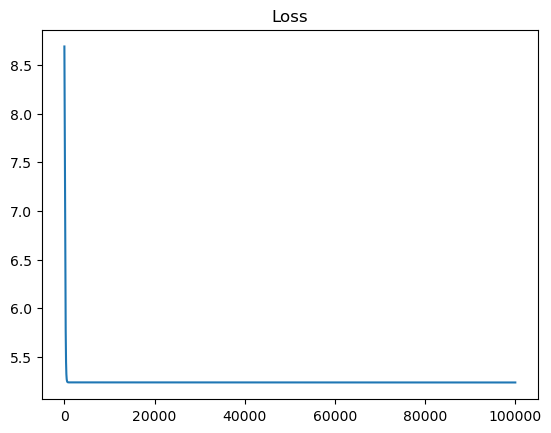

[[0.47815735]
 [0.47646614]
 [0.47787104]
 [0.47652916]
 [0.47758994]
 [0.47659342]
 [0.47731564]
 [0.47665888]
 [0.47704963]
 [0.47672548]
 [0.47679316]
 [0.47654727]
 [0.47686185]
 [0.47631279]
 [0.47693149]
 [0.47609031]
 [0.477002  ]
 [0.47588021]
 [0.47707329]
 [0.47568269]
 [0.47714528]]
Accuracy: 0.5238095238095238


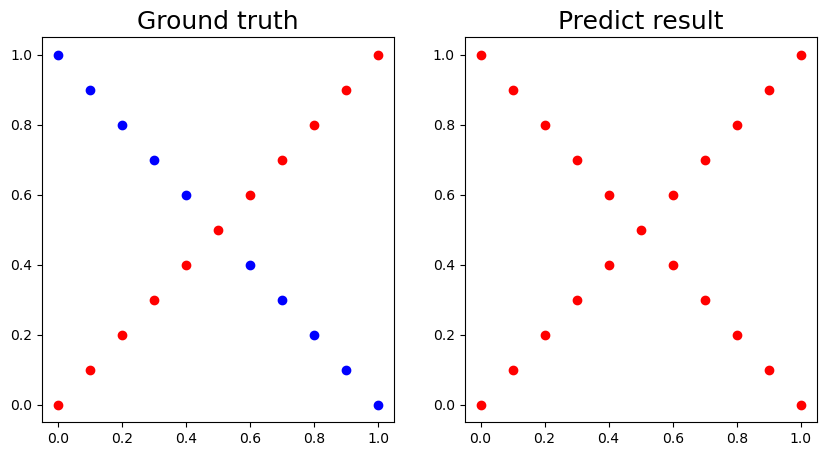

epoch 0, loss: 6.932078406266983
epoch 5000, loss: 5.991883936769137
epoch 10000, loss: 5.733296656109146
epoch 15000, loss: 5.584130372318907
epoch 20000, loss: 5.486483368735263
epoch 25000, loss: 5.418744992046064
epoch 30000, loss: 5.3703432207477855
epoch 35000, loss: 5.335215128058456
epoch 40000, loss: 5.309509832166716
epoch 45000, loss: 5.290620972346641
epoch 50000, loss: 5.276715210596276
epoch 55000, loss: 5.266472914893718
epoch 60000, loss: 5.258931289449252
epoch 65000, loss: 5.253382497125573
epoch 70000, loss: 5.24930407262967
epoch 75000, loss: 5.246309729957516
epoch 80000, loss: 5.244113797116457
epoch 85000, loss: 5.242505140810688
epoch 90000, loss: 5.241327892539873
epoch 95000, loss: 5.240467142005596
epoch 100000, loss: 5.239838300412955


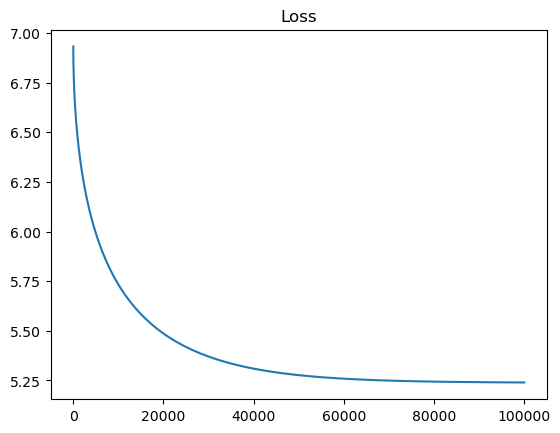

[[0.48562798]
 [0.48449447]
 [0.48553366]
 [0.48462711]
 [0.48544014]
 [0.4847607 ]
 [0.48534752]
 [0.48489505]
 [0.4852559 ]
 [0.48502999]
 [0.48516534]
 [0.48507595]
 [0.48530092]
 [0.48498778]
 [0.48543654]
 [0.48490092]
 [0.48557203]
 [0.48481544]
 [0.48570719]
 [0.48473139]
 [0.48584186]]
Accuracy: 0.5238095238095238


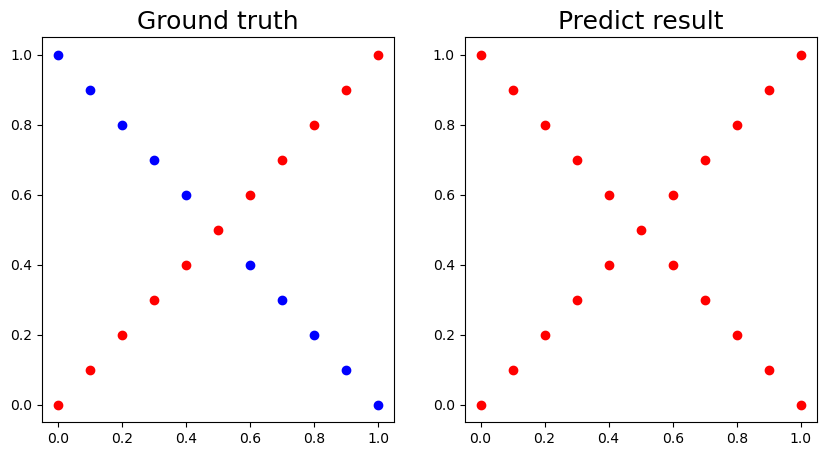

epoch 0, loss: 5.805314606864277
epoch 5000, loss: 5.238467758371383
epoch 10000, loss: 5.2383332743678785
epoch 15000, loss: 5.238227403015778
epoch 20000, loss: 5.238132881960526
epoch 25000, loss: 5.2380356834982935
epoch 30000, loss: 5.237919815848649
epoch 35000, loss: 5.237760237329895
epoch 40000, loss: 5.237507049446061
epoch 45000, loss: 5.237038265517591
epoch 50000, loss: 5.235974522909556
epoch 55000, loss: 5.2325854933177895
epoch 60000, loss: 5.208650598845527
epoch 65000, loss: 4.6423386050705355
epoch 70000, loss: 1.2641877127597816
epoch 75000, loss: 0.31148856756217624
epoch 80000, loss: 0.08142015811988948
epoch 85000, loss: 0.035547764920114674
epoch 90000, loss: 0.020652665260889075
epoch 95000, loss: 0.013932556986598033
epoch 100000, loss: 0.01026512022154495


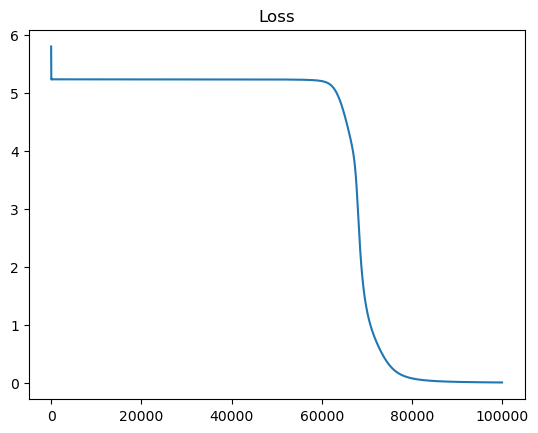

[[1.71294996e-04]
 [9.99540075e-01]
 [1.33613700e-03]
 [9.99660341e-01]
 [8.32162821e-03]
 [9.99714551e-01]
 [2.69038724e-02]
 [9.99509877e-01]
 [4.17967792e-02]
 [9.48899286e-01]
 [3.70397019e-02]
 [2.32648298e-02]
 [9.45412757e-01]
 [1.24966900e-02]
 [9.99568469e-01]
 [6.57077515e-03]
 [9.99856820e-01]
 [3.65220556e-03]
 [9.99893192e-01]
 [2.21534457e-03]
 [9.99905833e-01]]
Accuracy: 1.0


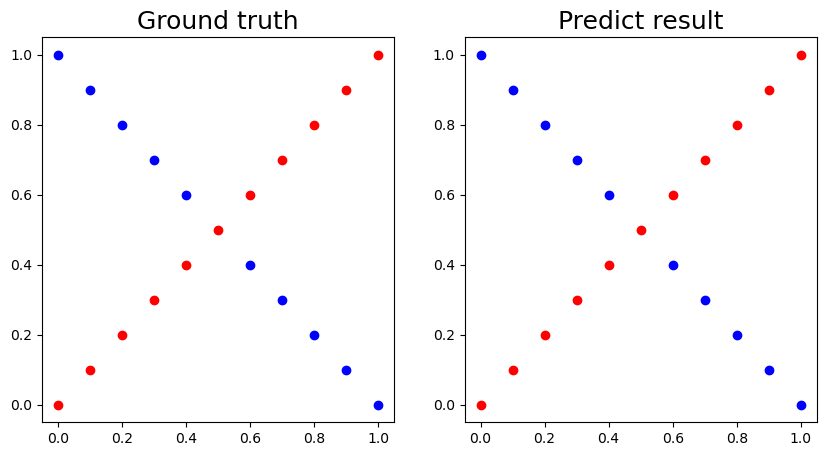

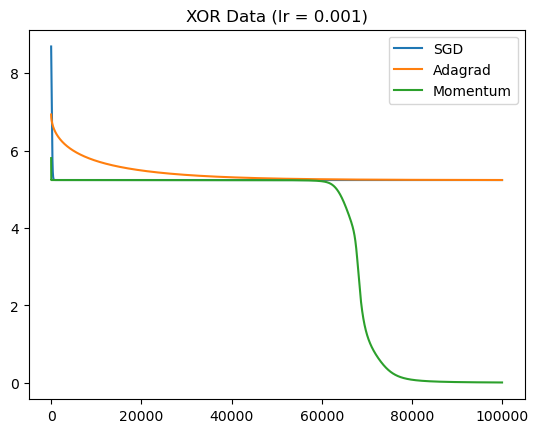

In [71]:
loss1 = Traning_and_Test(NN1, generate_XOR_easy, lr=0.001)
loss2 = Traning_and_Test(NN_adagrad, generate_XOR_easy, lr=0.001)
loss3 = Traning_and_Test(NN_momentum, generate_XOR_easy, lr=0.001)
plt.title('XOR Data (lr = 0.001)')
plt.plot(loss1, label='SGD')
plt.plot(loss2, label='Adagrad')
plt.plot(loss3, label='Momentum')
plt.legend()
plt.show()

In [118]:
class NN_Conv:
    def __init__(self, X, Y, n_hidden=4, lr=0.1):
        self.X = X
        self.Y = Y
        self.n_hidden = n_hidden
        self.weights1 = Linear(self.X.shape[1], self.n_hidden)
        self.weights2 = Conv1d(self.n_hidden, 1)
        self.weights3 = Linear(3, 1)
        self.sigmoid1 = Sigmoid()
        self.sigmoid2 = Sigmoid()
        self.sigmoid3 = Sigmoid()
        self.lr = lr
        self.optimizer = SGD([self.weights1, self.weights2, self.weights3], self.lr)

    def forward(self, input):
        self.a1 = self.weights1.forward(input)
        self.b1 = self.sigmoid1.forward(self.a1)
        self.a2 = self.weights2.forward(self.b1)
        self.b2 = self.sigmoid2.forward(self.a2)
        self.a3 = self.weights3.forward(self.b2)
        self.out = self.sigmoid3.forward(self.a3)
        return self.out
    
    def train(self):
        y = self.forward(self.X)
        y = y.reshape(-1, 1)
        loss = np.sum((y-self.Y)**2)
        
        # Backpropagation
        dloss_dy = 2*(y-self.Y)
        dou_da3 = self.sigmoid3.backward(dloss_dy)
        da3_db2 = self.weights3.backward(dou_da3)
        db2_da2 = self.sigmoid2.backward(da3_db2)
        da2_db1 = self.weights2.backward(db2_da2)
        db1_da1 = self.sigmoid1.backward(da2_db1)
        da1_dw1 = self.weights1.backward(db1_da1)
        
        # Update Weights
        self.optimizer.step()

        return loss

In [125]:
Traning_and_Test(NN_Conv, generate_linear)

ValueError: operands could not be broadcast together with shapes (100,2) (4,) (100,2) 